<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [3]:
download = False
if not os.path.isfile("./cifar-10-python.tar.gz"):
    download = True

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

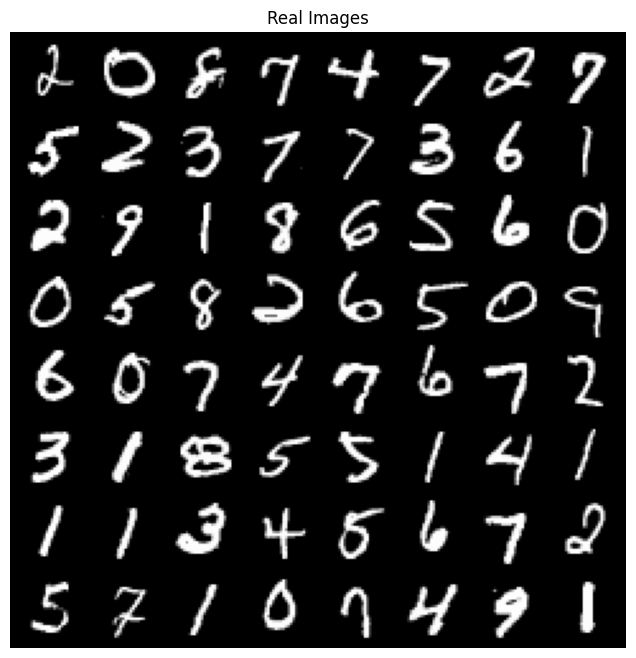

In [4]:
import matplotlib.pyplot as plt


real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

![image.png](attachment:./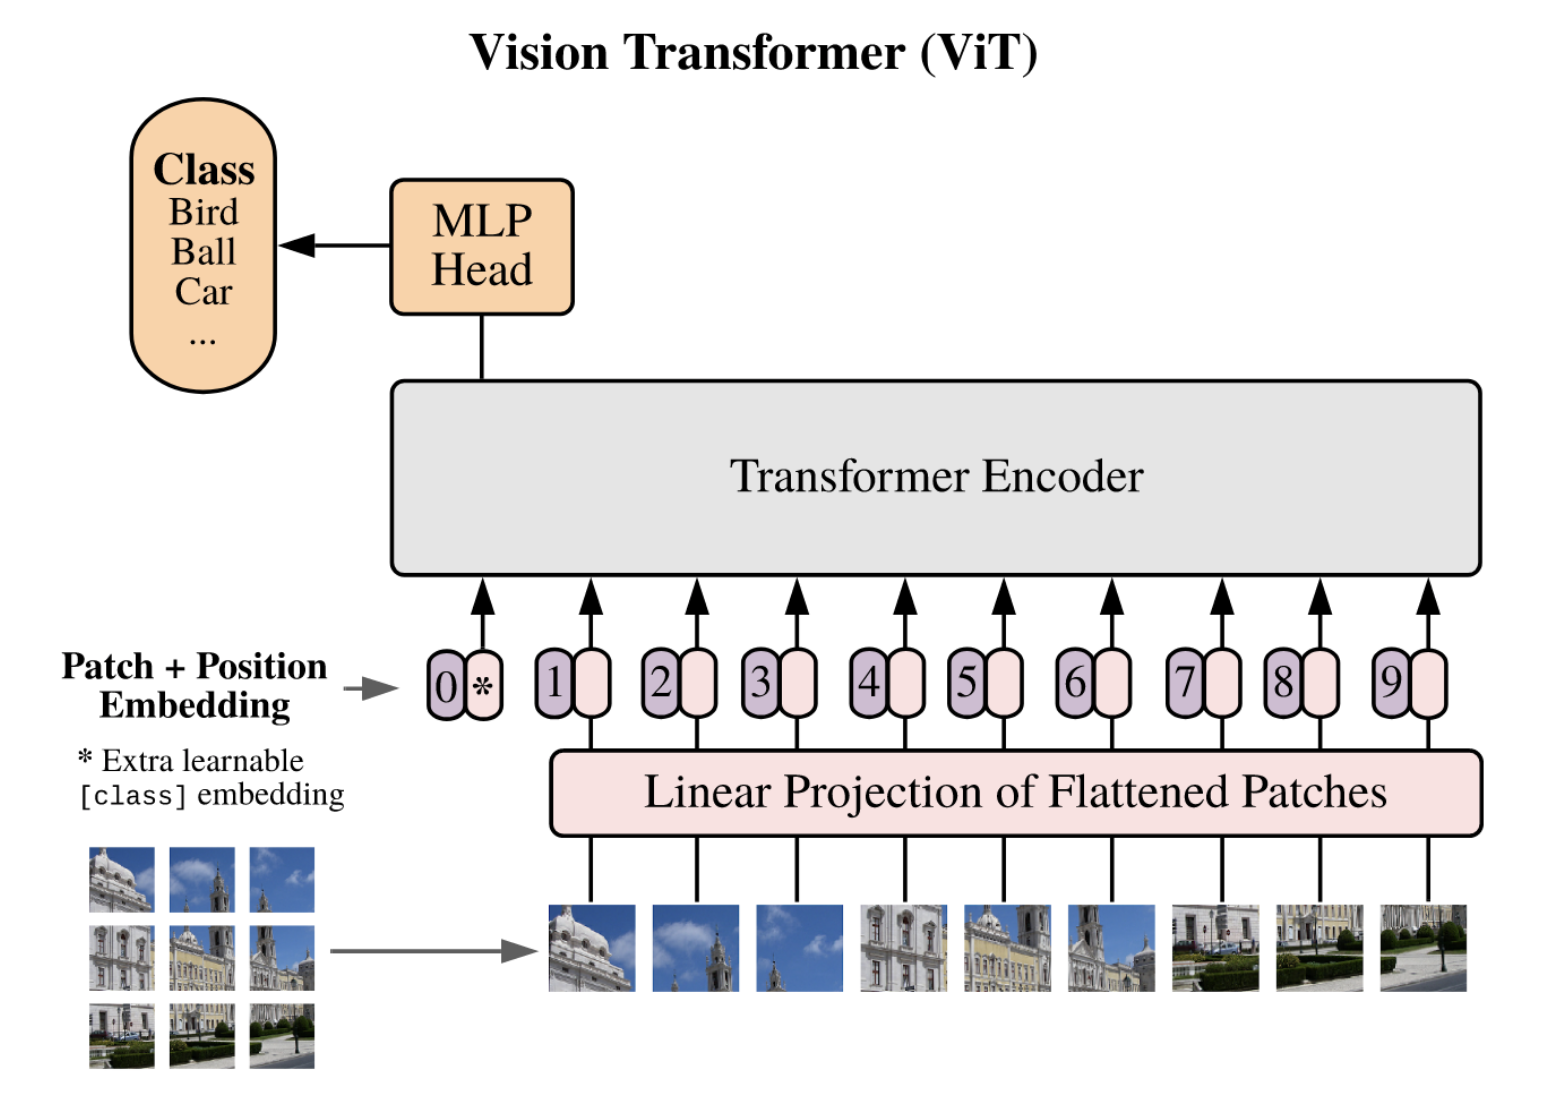)

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    """
      x.shape : (Batch, Channels, height, width)
    """
    x = self.projection(x)
    
    B, C, H, W = x.size() # Here C = embedding_dim

    # Reshape from B x C x H x W to B x N x C where N is H*W (the number of 'tokens').
    x = x.view(B, C, -1) # Flatten the H and W dimensions.
      
    # Shape is now B x C x N, we simply need to permute to get B x N x C 
    x = x.permute(0, 2, 1)

    # x.size() -> B, N, C
    return x

In [6]:
PatchEmbed(in_chan=2)(torch.randn(32, 2, 28, 28)).size()

torch.Size([32, 16, 128])

# Transformer encoder

![image.png](attachment:./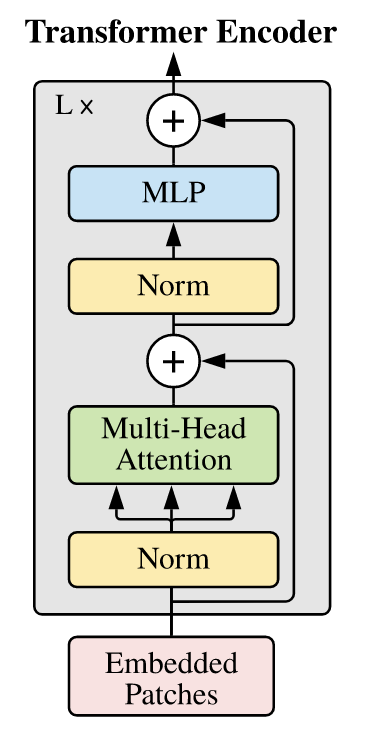)

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [7]:

class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.seq = nn.Sequential(nn.Linear(in_features, hid_features), nn.GELU(), nn.Linear(hid_features, in_features)) 

  def forward(self, x):
    return self.seq(x)


MLP(128, 512)(torch.randn(32, 16, 128)).size()

torch.Size([32, 16, 128])

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart? What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!

**Answer in the reports 😉**

## Q3: Self-attention

In [8]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim, final_linear=True):
    super().__init__()
    self.scale = embed_dim**0.5
    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    if final_linear:
      self.final_linear = nn.Linear(embed_dim, embed_dim)
    else:
      self.final_linear = lambda x: x

  def forward(self, x):
    """
    B : batch size
    N : nombre d'embedding = nombre de patch d'image 
    C : taille d'un embedding 
    """
    B, N, C = x.shape

    # Compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # Compute the final version using the attention V, and the final projection
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v
    return self.final_linear(x)

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

**Answer in the reports 😉**

In [9]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)
      
    print(q.size())

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO

    return x

  def transpose_qkv(self, X):
      """Transposition for parallel computation of multiple attention heads."""
      # Shape of input X: (batch_size, no. of queries or key-value pairs, num_hiddens). 
      # Shape of output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)
      X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
      # Shape of output X: (batch_size, num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      X = X.permute(0, 2, 1, 3)
      # Shape of output: (batch_size * num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      return X.reshape(-1, X.shape[2], X.shape[3])
  
  
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])


torch.Size([32, 16, 6])

In [10]:
class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # Validate that the embedding dimension is divisible by the number of heads
        if embed_dim % num_heads != 0:
            raise ValueError("Embedding dimension must be divisible by the number of heads.")

        self.num_heads = num_heads
        head_dim = embed_dim // num_heads  # Determine the dimension size of each head
        self.scale = head_dim ** -0.5  # Scale factor for the dot product

        # These are the linear layers used for the multi-head attention
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)

        # This is the final linear layer used after the self-attention
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # Batch size, number of tokens, and embedding dimension

        # First, we pass through the linear layers
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        # Reshape Q, K, V for the attention computation
        q = q.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        k = k.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        v = v.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)

        # Scaled dot-product attention calculation
        ###################### On divise ou multipli par la scale attention ?
        attention_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale  # Shape: (B, num_heads, N, N)
        attention = F.softmax(attention_scores, dim=-1)
        out = torch.matmul(attention, v)  # Shape: (B, num_heads, N, head_dim)

        # Concatenating the multi-head attention results
        out = out.permute(0, 2, 1, 3).contiguous().view(B, N, C)  # Shape: (B, N, C)

        # Final linear layer
        out = self.projection(out)  # Shape: (B, N, C)

        return out

    
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).size()

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

**Equations**:

**Answer in the reports 😉**

In [11]:
# normalisation : use layer norm from pytorch, similar to batch normalisation but the mean & std is computed across the channel feature
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)

  def forward(self, x):
    out = self.norm(x)
    out = self.attention(out)
    x = out + x
    out = self.norm(x)
    out = self.mlp(out)
    return out + x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

In [12]:

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()

        # Multi-head self-attention mechanism
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward neural network (MLP)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, mlp_ratio * embed_dim),  # Linear layer
            nn.GELU(),  # Activation function
            nn.Linear(mlp_ratio * embed_dim, embed_dim),  # Linear layer
        )

    def forward(self, x):
        # Apply multi-head attention followed by layer normalization
        attention_output = self.attention(x)
        x = self.norm1(x + attention_output)  # Residual connection

        # Apply feed-forward neural network followed by layer normalization
        feed_forward_output = self.feed_forward(x)
        x = self.norm2(x + feed_forward_output)  # Residual connection

        return x

    
Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

![](https://www.researchgate.net/publication/348947034/figure/fig2/AS:986572736446471@1612228678819/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the.png)

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

1. Explain what is a Class token and why we use it? 
2. Explain what is the positional embedding (PE) and why it is important?

**Answer in the reports 😉**

### Sinusoidal PE

In [13]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10, num_heads=4, mlp_ratio=4):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.ones(1, embed_dim),requires_grad=False)
    self.pos_embed = nn.Parameter(self.get_positional_embeddings(num_patches+1, embed_dim), requires_grad=False)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(Block(embed_dim, num_heads=num_heads, mlp_ratio=num_heads))
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Sequential(
            nn.Linear(embed_dim, nb_classes),
            nn.Softmax(dim=-1)
        )

  @staticmethod
  def get_positional_embeddings(sequence_length, d):
    """
    given the number of tokens and the dimensionality of each of them, 
    outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.
    """
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
  
  def forward(self, x):
    batch_size = x.size(0)
    x = self.patch_embed(x) ## image to patches => B, N, C

    ## concatenating class token of shape (1, embedding dim) for every example
    x = torch.cat((self.class_token.repeat(batch_size, 1, 1), x), dim=1)
    
    ## adding positional embedding
    x += self.pos_embed.repeat(batch_size, 1, 1)

    ## forward in the transformer
    x = self.blocks(x)[:, 0, :] # We take only the CLS token
    
    ## Normalize the output
    x = self.norm(x)

    output = self.head(x) ## classification output

    return output
  


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader, num_classes):
  model.eval()
  acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  loss = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)
    loss += F.cross_entropy(yhat, y)
    acc(yhat.argmax(dim=1), y)

  model.train()
  return loss.item(), acc.compute().item()

And run! Feel free to try other hyperparameters.

In [15]:
import torchmetrics
from tqdm import tqdm
def main(epochs = 10, embed_dim = 32, patch_size = 7, nb_blocks = 2, num_classes=10, num_heads=4, mlp_ratio=4, model=None, tqdm_batch=False, lr=0.001):
  if not model:
    model = ViT(embed_dim, nb_blocks, patch_size, num_heads=num_heads, mlp_ratio=mlp_ratio).cuda()
  if tqdm_batch:
    train_loader_main = tqdm(train_loader)
  else:
    train_loader_main = train_loader
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  acc_train = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  acc_train_list = []
  acc_test_list = []
  loss_train_list = []
  loss_test_list = []

  for epoch in (pbar := tqdm(range(epochs))):
    train_loss = 0.
    for x, y in train_loader_main:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()
      acc_train(yhat.argmax(dim=1), y)
      train_loss += loss.item()
    loss_train_list.append(train_loss / len(train_loader))
    acc_train_list.append(acc_train.compute().item())
    acc_train.reset()
    
    # Test eval
    loss_test, acc_test = eval_model(model, test_loader, num_classes)
    acc_test_list.append(acc_test)
    loss_test_list.append(loss_test)
    pbar.set_description(f"acc_train {acc_train_list[-1]:.3f} | acc_test {acc_test:.3f}")
  return acc_train_list, acc_test_list, loss_train_list, loss_test_list
  #   print(f"--- Epoch {epoch} ---")
  #   print(f"Train loss: {train_loss / len(train_loader)}")
  # print(f"Test accuracy: {acc}")
# main()

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [16]:
def plot_plot_optimizers(plot_optimizers, save_name=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    for opt, values in plot_optimizers.items():
        ax[0].plot(values[0], label=f"{opt}")
        ax[1].plot(values[1], label=f"{opt}")
        ax[2].plot(values[2], label=f"{opt}")
        ax[3].plot(values[3], label=f"{opt}")

    ax[0].set_title("Train accuracy / epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim([0, 1])

    ax[1].set_title("Test accuracy / epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_ylim([0, 1])

    ax[2].set_title("Train loss / epoch")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Loss")

    ax[3].set_title("Test loss / epoch")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("Loss")

    plt.legend()
    plt.tight_layout()
    if save_name:
        plt.savefig(f"{save_name}.pdf", dpi=100, bbox_inches="tight")
    plt.show()

In [17]:
# plot_optimizers_embed_dim = {}
# for embed_dim in [16,32,64,128]:
#     stats = main(epochs=15, embed_dim=embed_dim)
#     plot_optimizers_embed_dim[embed_dim] = stats

In [18]:
# plot_plot_optimizers(plot_optimizers_embed_dim, 'embed_dim_influence')

In [19]:
# plot_optimizers_patch_size = {}
# for patch_size in [2,4,7,14, 28]:
#     stats = main(epochs=15, patch_size=patch_size)
#     plot_optimizers_patch_size[patch_size] = stats

In [20]:
# plot_plot_optimizers(plot_optimizers_patch_size, 'patch_size_influence')

In [21]:
# plot_optimizers_nb_blocks = {}
# for nb_blocks in [2,4,6,8]:
#     stats = main(epochs=15, nb_blocks=nb_blocks)
#     plot_optimizers_nb_blocks[nb_blocks] = stats

In [22]:
# plot_plot_optimizers(plot_optimizers_nb_blocks, 'nb_block_influence')

In [23]:
# plot_optimizers_num_heads = {}
# for num_heads in [2,4,8,16]:
#     stats = main(epochs=15, num_heads=num_heads)
#     plot_optimizers_num_heads[num_heads] = stats

In [24]:
# plot_plot_optimizers(plot_optimizers_num_heads, 'num_heads_influence')

In [25]:
# plot_optimizers_mlp_ratio = {}
# for mlp_ratio in [2,4,6,8]:
#     stats = main(epochs=15, mlp_ratio=mlp_ratio)
#     plot_optimizers_mlp_ratio[mlp_ratio] = stats

In [26]:
# plot_plot_optimizers(plot_optimizers_mlp_ratio, 'mlp_ratio_influence')

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [27]:
%pip install timm > /dev/null

Note: you may need to restart the kernel to use updated packages.


a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [28]:
import timm
# [k for k in timm.list_models() if 'vit_base' in k]

In [29]:
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
try:
    model(torch.randn(1, 1, 28, 28))
except AssertionError as err:
    print(err)

Input height (28) doesn't match model (224).


The model vit_base_patch16_224 is trained on 224x224 images from the ImageNet dataset. In the first layer of the ViT, the input image is divided into fixed-size patches to create embedded vectors. It's crucial to maintain the same image size as the one the model was designed for. 

In this case, it necessitates resizing the images to 224x224 RGB pixels. However, this may not be ideal as resizing could distort the images and potentially affect the model's performance.

In [30]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 8, 8) # adapt number of channels to fit in ViT 
# by coping the image and not resizing yet (see next cell)
display(x.size())
model(x).shape

torch.Size([32, 3, 224, 224])

torch.Size([32, 10])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [31]:
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
data_cfg # figure out which transformations were used for a given pretrained model

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [32]:
transform = timm.data.create_transform(**data_cfg)
transform_rgb = lambda x: transform(x.convert('RGB'))

In [33]:
model.cuda()
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform_rgb)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform_rgb)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=64)

c) redo the training with the pretrained ViT-S




In [34]:
stats_vit = main(model=model, epochs=15, tqdm_batch=True, lr=0.01)


  0%|                                         | 0/938 [00:00<?, ?it/s]


  0%|                                          | 0/15 [00:00<?, ?it/s]


  0%|                                 | 1/938 [00:00<11:17,  1.38it/s]


  0%|                                 | 2/938 [00:01<10:01,  1.56it/s]


  0%|                                 | 3/938 [00:01<09:22,  1.66it/s]


  0%|▏                                | 4/938 [00:02<09:03,  1.72it/s]


  1%|▏                                | 5/938 [00:02<08:50,  1.76it/s]


  1%|▏                                | 6/938 [00:03<08:42,  1.78it/s]


  1%|▏                                | 7/938 [00:04<08:36,  1.80it/s]


  1%|▎                                | 8/938 [00:04<08:32,  1.81it/s]


  1%|▎                                | 9/938 [00:05<08:30,  1.82it/s]


  1%|▎                               | 10/938 [00:05<08:28,  1.82it/s]


  1%|▍                               | 11/938 [00:06<08:25,  1.83it/s]


  1%|▍                               | 12/938 [00:06<08:23,  1.84it/s]


  1%|▍                               | 13/938 [00:07<08:22,  1.84it/s]


  1%|▍                               | 14/938 [00:07<08:20,  1.85it/s]


  2%|▌                               | 15/938 [00:08<08:19,  1.85it/s]


  2%|▌                               | 16/938 [00:08<08:18,  1.85it/s]


  2%|▌                               | 17/938 [00:09<08:18,  1.85it/s]


  2%|▌                               | 18/938 [00:10<08:17,  1.85it/s]


  2%|▋                               | 19/938 [00:10<08:17,  1.85it/s]


  2%|▋                               | 20/938 [00:11<08:17,  1.85it/s]


  2%|▋                               | 21/938 [00:11<08:30,  1.80it/s]


  2%|▊                               | 22/938 [00:12<08:25,  1.81it/s]


  2%|▊                               | 23/938 [00:12<08:21,  1.82it/s]


  3%|▊                               | 24/938 [00:13<08:18,  1.83it/s]


  3%|▊                               | 25/938 [00:13<08:26,  1.80it/s]


  3%|▉                               | 26/938 [00:14<08:22,  1.82it/s]


  3%|▉                               | 27/938 [00:14<08:19,  1.83it/s]


  3%|▉                               | 28/938 [00:15<08:17,  1.83it/s]


  3%|▉                               | 29/938 [00:16<08:15,  1.84it/s]


  3%|█                               | 30/938 [00:16<08:14,  1.84it/s]


  3%|█                               | 31/938 [00:17<08:13,  1.84it/s]


  3%|█                               | 32/938 [00:17<08:12,  1.84it/s]


  4%|█▏                              | 33/938 [00:18<08:12,  1.84it/s]


  4%|█▏                              | 34/938 [00:18<08:11,  1.84it/s]


  4%|█▏                              | 35/938 [00:19<08:10,  1.84it/s]


  4%|█▏                              | 36/938 [00:19<08:10,  1.84it/s]


  4%|█▎                              | 37/938 [00:20<08:10,  1.84it/s]


  4%|█▎                              | 38/938 [00:20<08:09,  1.84it/s]


  4%|█▎                              | 39/938 [00:21<08:08,  1.84it/s]


  4%|█▎                              | 40/938 [00:22<08:08,  1.84it/s]


  4%|█▍                              | 41/938 [00:22<08:08,  1.84it/s]


  4%|█▍                              | 42/938 [00:23<08:08,  1.84it/s]


  5%|█▍                              | 43/938 [00:23<08:07,  1.84it/s]


  5%|█▌                              | 44/938 [00:24<08:06,  1.84it/s]


  5%|█▌                              | 45/938 [00:24<08:06,  1.84it/s]


  5%|█▌                              | 46/938 [00:25<08:06,  1.84it/s]


  5%|█▌                              | 47/938 [00:25<08:05,  1.84it/s]


  5%|█▋                              | 48/938 [00:26<08:09,  1.82it/s]


  5%|█▋                              | 49/938 [00:26<08:07,  1.82it/s]


  5%|█▋                              | 50/938 [00:27<08:06,  1.82it/s]


  5%|█▋                              | 51/938 [00:28<08:05,  1.83it/s]


  6%|█▊                              | 52/938 [00:28<08:04,  1.83it/s]


  6%|█▊                              | 53/938 [00:29<08:04,  1.83it/s]


  6%|█▊                              | 54/938 [00:29<08:03,  1.83it/s]


  6%|█▉                              | 55/938 [00:30<08:02,  1.83it/s]


  6%|█▉                              | 56/938 [00:30<08:02,  1.83it/s]


  6%|█▉                              | 57/938 [00:31<08:01,  1.83it/s]


  6%|█▉                              | 58/938 [00:31<08:01,  1.83it/s]


  6%|██                              | 59/938 [00:32<08:00,  1.83it/s]


  6%|██                              | 60/938 [00:32<07:59,  1.83it/s]


  7%|██                              | 61/938 [00:33<07:59,  1.83it/s]


  7%|██                              | 62/938 [00:34<07:58,  1.83it/s]


  7%|██▏                             | 63/938 [00:34<07:57,  1.83it/s]


  7%|██▏                             | 64/938 [00:35<07:56,  1.83it/s]


  7%|██▏                             | 65/938 [00:35<07:56,  1.83it/s]


  7%|██▎                             | 66/938 [00:36<07:56,  1.83it/s]


  7%|██▎                             | 67/938 [00:36<07:56,  1.83it/s]


  7%|██▎                             | 68/938 [00:37<07:56,  1.83it/s]


  7%|██▎                             | 69/938 [00:37<07:54,  1.83it/s]


  7%|██▍                             | 70/938 [00:38<07:54,  1.83it/s]


  8%|██▍                             | 71/938 [00:38<07:54,  1.83it/s]


  8%|██▍                             | 72/938 [00:39<07:53,  1.83it/s]


  8%|██▍                             | 73/938 [00:40<07:52,  1.83it/s]


  8%|██▌                             | 74/938 [00:40<07:52,  1.83it/s]


  8%|██▌                             | 75/938 [00:41<07:51,  1.83it/s]


  8%|██▌                             | 76/938 [00:41<07:51,  1.83it/s]


  8%|██▋                             | 77/938 [00:42<07:50,  1.83it/s]


  8%|██▋                             | 78/938 [00:42<07:50,  1.83it/s]


  8%|██▋                             | 79/938 [00:43<07:50,  1.83it/s]


  9%|██▋                             | 80/938 [00:43<07:49,  1.83it/s]


  9%|██▊                             | 81/938 [00:44<07:48,  1.83it/s]


  9%|██▊                             | 82/938 [00:44<07:48,  1.83it/s]


  9%|██▊                             | 83/938 [00:45<07:48,  1.83it/s]


  9%|██▊                             | 84/938 [00:46<07:47,  1.83it/s]


  9%|██▉                             | 85/938 [00:46<07:47,  1.83it/s]


  9%|██▉                             | 86/938 [00:47<07:46,  1.83it/s]


  9%|██▉                             | 87/938 [00:47<07:46,  1.82it/s]


  9%|███                             | 88/938 [00:48<07:45,  1.82it/s]


  9%|███                             | 89/938 [00:48<07:45,  1.82it/s]


 10%|███                             | 90/938 [00:49<07:45,  1.82it/s]


 10%|███                             | 91/938 [00:49<07:44,  1.82it/s]


 10%|███▏                            | 92/938 [00:50<07:45,  1.82it/s]


 10%|███▏                            | 93/938 [00:51<07:44,  1.82it/s]


 10%|███▏                            | 94/938 [00:51<07:43,  1.82it/s]


 10%|███▏                            | 95/938 [00:52<07:43,  1.82it/s]


 10%|███▎                            | 96/938 [00:52<07:42,  1.82it/s]


 10%|███▎                            | 97/938 [00:53<07:42,  1.82it/s]


 10%|███▎                            | 98/938 [00:53<07:41,  1.82it/s]


 11%|███▍                            | 99/938 [00:54<07:41,  1.82it/s]


 11%|███▎                           | 100/938 [00:54<07:40,  1.82it/s]


 11%|███▎                           | 101/938 [00:55<07:40,  1.82it/s]


 11%|███▎                           | 102/938 [00:55<07:39,  1.82it/s]


 11%|███▍                           | 103/938 [00:56<07:39,  1.82it/s]


 11%|███▍                           | 104/938 [00:57<07:38,  1.82it/s]


 11%|███▍                           | 105/938 [00:57<07:38,  1.82it/s]


 11%|███▌                           | 106/938 [00:58<07:37,  1.82it/s]


 11%|███▌                           | 107/938 [00:58<07:37,  1.82it/s]


 12%|███▌                           | 108/938 [00:59<07:36,  1.82it/s]


 12%|███▌                           | 109/938 [00:59<07:36,  1.82it/s]


 12%|███▋                           | 110/938 [01:00<07:35,  1.82it/s]


 12%|███▋                           | 111/938 [01:00<07:35,  1.82it/s]


 12%|███▋                           | 112/938 [01:01<07:34,  1.82it/s]


 12%|███▋                           | 113/938 [01:02<07:33,  1.82it/s]


 12%|███▊                           | 114/938 [01:02<07:33,  1.82it/s]


 12%|███▊                           | 115/938 [01:03<07:33,  1.82it/s]


 12%|███▊                           | 116/938 [01:03<07:32,  1.82it/s]


 12%|███▊                           | 117/938 [01:04<07:31,  1.82it/s]


 13%|███▉                           | 118/938 [01:04<07:31,  1.82it/s]


 13%|███▉                           | 119/938 [01:05<07:31,  1.81it/s]


 13%|███▉                           | 120/938 [01:05<07:31,  1.81it/s]


 13%|███▉                           | 121/938 [01:06<07:30,  1.82it/s]


 13%|████                           | 122/938 [01:06<07:29,  1.81it/s]


 13%|████                           | 123/938 [01:07<07:28,  1.82it/s]


 13%|████                           | 124/938 [01:08<07:28,  1.82it/s]


 13%|████▏                          | 125/938 [01:08<07:27,  1.82it/s]


 13%|████▏                          | 126/938 [01:09<07:27,  1.81it/s]


 14%|████▏                          | 127/938 [01:09<07:26,  1.81it/s]


 14%|████▏                          | 128/938 [01:10<07:26,  1.81it/s]


 14%|████▎                          | 129/938 [01:10<07:26,  1.81it/s]


 14%|████▎                          | 130/938 [01:11<07:25,  1.82it/s]


 14%|████▎                          | 131/938 [01:11<07:24,  1.82it/s]


 14%|████▎                          | 132/938 [01:12<07:23,  1.82it/s]


 14%|████▍                          | 133/938 [01:13<07:23,  1.82it/s]


 14%|████▍                          | 134/938 [01:13<07:22,  1.82it/s]


 14%|████▍                          | 135/938 [01:14<07:22,  1.81it/s]


 14%|████▍                          | 136/938 [01:14<07:21,  1.82it/s]


 15%|████▌                          | 137/938 [01:15<07:21,  1.81it/s]


 15%|████▌                          | 138/938 [01:15<07:21,  1.81it/s]


 15%|████▌                          | 139/938 [01:16<07:20,  1.82it/s]


 15%|████▋                          | 140/938 [01:16<07:19,  1.81it/s]


 15%|████▋                          | 141/938 [01:17<07:19,  1.81it/s]


 15%|████▋                          | 142/938 [01:18<07:19,  1.81it/s]


 15%|████▋                          | 143/938 [01:18<07:18,  1.81it/s]


 15%|████▊                          | 144/938 [01:19<07:17,  1.81it/s]


 15%|████▊                          | 145/938 [01:19<07:17,  1.81it/s]


 16%|████▊                          | 146/938 [01:20<07:16,  1.81it/s]


 16%|████▊                          | 147/938 [01:20<07:16,  1.81it/s]


 16%|████▉                          | 148/938 [01:21<07:16,  1.81it/s]


 16%|████▉                          | 149/938 [01:21<07:15,  1.81it/s]


 16%|████▉                          | 150/938 [01:22<07:15,  1.81it/s]


 16%|████▉                          | 151/938 [01:22<07:14,  1.81it/s]


 16%|█████                          | 152/938 [01:23<07:14,  1.81it/s]


 16%|█████                          | 153/938 [01:24<07:13,  1.81it/s]


 16%|█████                          | 154/938 [01:24<07:13,  1.81it/s]


 17%|█████                          | 155/938 [01:25<07:12,  1.81it/s]


 17%|█████▏                         | 156/938 [01:25<07:12,  1.81it/s]


 17%|█████▏                         | 157/938 [01:26<07:11,  1.81it/s]


 17%|█████▏                         | 158/938 [01:26<07:10,  1.81it/s]


 17%|█████▎                         | 159/938 [01:27<07:10,  1.81it/s]


 17%|█████▎                         | 160/938 [01:27<07:09,  1.81it/s]


 17%|█████▎                         | 161/938 [01:28<07:09,  1.81it/s]


 17%|█████▎                         | 162/938 [01:29<07:08,  1.81it/s]


 17%|█████▍                         | 163/938 [01:29<07:08,  1.81it/s]


 17%|█████▍                         | 164/938 [01:30<07:07,  1.81it/s]


 18%|█████▍                         | 165/938 [01:30<07:07,  1.81it/s]


 18%|█████▍                         | 166/938 [01:31<07:09,  1.80it/s]


 18%|█████▌                         | 167/938 [01:31<07:07,  1.80it/s]


 18%|█████▌                         | 168/938 [01:32<07:06,  1.80it/s]


 18%|█████▌                         | 169/938 [01:32<07:05,  1.81it/s]


 18%|█████▌                         | 170/938 [01:33<07:05,  1.81it/s]


 18%|█████▋                         | 171/938 [01:34<07:04,  1.81it/s]


 18%|█████▋                         | 172/938 [01:34<07:03,  1.81it/s]


 18%|█████▋                         | 173/938 [01:35<07:03,  1.81it/s]


 19%|█████▊                         | 174/938 [01:35<07:02,  1.81it/s]


 19%|█████▊                         | 175/938 [01:36<07:01,  1.81it/s]


 19%|█████▊                         | 176/938 [01:36<07:01,  1.81it/s]


 19%|█████▊                         | 177/938 [01:37<07:00,  1.81it/s]


 19%|█████▉                         | 178/938 [01:37<06:59,  1.81it/s]


 19%|█████▉                         | 179/938 [01:38<06:59,  1.81it/s]


 19%|█████▉                         | 180/938 [01:39<06:58,  1.81it/s]


 19%|█████▉                         | 181/938 [01:39<06:58,  1.81it/s]


 19%|██████                         | 182/938 [01:40<06:57,  1.81it/s]


 20%|██████                         | 183/938 [01:40<06:57,  1.81it/s]


 20%|██████                         | 184/938 [01:41<06:56,  1.81it/s]


 20%|██████                         | 185/938 [01:41<06:56,  1.81it/s]


 20%|██████▏                        | 186/938 [01:42<06:55,  1.81it/s]


 20%|██████▏                        | 187/938 [01:42<06:54,  1.81it/s]


 20%|██████▏                        | 188/938 [01:43<06:54,  1.81it/s]


 20%|██████▏                        | 189/938 [01:43<06:53,  1.81it/s]


 20%|██████▎                        | 190/938 [01:44<06:53,  1.81it/s]


 20%|██████▎                        | 191/938 [01:45<06:52,  1.81it/s]


 20%|██████▎                        | 192/938 [01:45<06:52,  1.81it/s]


 21%|██████▍                        | 193/938 [01:46<06:51,  1.81it/s]


 21%|██████▍                        | 194/938 [01:46<06:51,  1.81it/s]


 21%|██████▍                        | 195/938 [01:47<06:50,  1.81it/s]


 21%|██████▍                        | 196/938 [01:47<06:49,  1.81it/s]


 21%|██████▌                        | 197/938 [01:48<06:49,  1.81it/s]


 21%|██████▌                        | 198/938 [01:48<06:48,  1.81it/s]


 21%|██████▌                        | 199/938 [01:49<06:48,  1.81it/s]


 21%|██████▌                        | 200/938 [01:50<06:47,  1.81it/s]


 21%|██████▋                        | 201/938 [01:50<06:47,  1.81it/s]


 22%|██████▋                        | 202/938 [01:51<06:46,  1.81it/s]


 22%|██████▋                        | 203/938 [01:51<06:46,  1.81it/s]


 22%|██████▋                        | 204/938 [01:52<06:45,  1.81it/s]


 22%|██████▊                        | 205/938 [01:52<06:45,  1.81it/s]


 22%|██████▊                        | 206/938 [01:53<06:44,  1.81it/s]


 22%|██████▊                        | 207/938 [01:53<06:44,  1.81it/s]


 22%|██████▊                        | 208/938 [01:54<06:43,  1.81it/s]


 22%|██████▉                        | 209/938 [01:55<06:42,  1.81it/s]


 22%|██████▉                        | 210/938 [01:55<06:44,  1.80it/s]


 22%|██████▉                        | 211/938 [01:56<06:43,  1.80it/s]


 23%|███████                        | 212/938 [01:56<06:42,  1.81it/s]


 23%|███████                        | 213/938 [01:57<06:41,  1.81it/s]


 23%|███████                        | 214/938 [01:57<06:40,  1.81it/s]


 23%|███████                        | 215/938 [01:58<06:40,  1.81it/s]


 23%|███████▏                       | 216/938 [01:58<06:39,  1.81it/s]


 23%|███████▏                       | 217/938 [01:59<06:38,  1.81it/s]


 23%|███████▏                       | 218/938 [02:00<06:37,  1.81it/s]


 23%|███████▏                       | 219/938 [02:00<06:37,  1.81it/s]


 23%|███████▎                       | 220/938 [02:01<06:36,  1.81it/s]


 24%|███████▎                       | 221/938 [02:01<06:35,  1.81it/s]


 24%|███████▎                       | 222/938 [02:02<06:35,  1.81it/s]


 24%|███████▎                       | 223/938 [02:02<06:34,  1.81it/s]


 24%|███████▍                       | 224/938 [02:03<06:34,  1.81it/s]


 24%|███████▍                       | 225/938 [02:03<06:34,  1.81it/s]


 24%|███████▍                       | 226/938 [02:04<06:33,  1.81it/s]


 24%|███████▌                       | 227/938 [02:05<06:40,  1.77it/s]


 24%|███████▌                       | 228/938 [02:05<06:37,  1.79it/s]


 24%|███████▌                       | 229/938 [02:06<06:35,  1.79it/s]


 25%|███████▌                       | 230/938 [02:06<06:35,  1.79it/s]


 25%|███████▋                       | 231/938 [02:07<06:42,  1.76it/s]


 25%|███████▋                       | 232/938 [02:07<06:38,  1.77it/s]


 25%|███████▋                       | 233/938 [02:08<06:35,  1.78it/s]


 25%|███████▋                       | 234/938 [02:08<06:33,  1.79it/s]


 25%|███████▊                       | 235/938 [02:09<06:31,  1.80it/s]


 25%|███████▊                       | 236/938 [02:10<06:30,  1.80it/s]


 25%|███████▊                       | 237/938 [02:10<06:29,  1.80it/s]


 25%|███████▊                       | 238/938 [02:11<06:27,  1.80it/s]


 25%|███████▉                       | 239/938 [02:11<06:27,  1.81it/s]


 26%|███████▉                       | 240/938 [02:12<06:26,  1.81it/s]


 26%|███████▉                       | 241/938 [02:12<06:25,  1.81it/s]


 26%|███████▉                       | 242/938 [02:13<06:25,  1.81it/s]


 26%|████████                       | 243/938 [02:13<06:24,  1.81it/s]


 26%|████████                       | 244/938 [02:14<06:26,  1.79it/s]


 26%|████████                       | 245/938 [02:15<06:28,  1.78it/s]


 26%|████████▏                      | 246/938 [02:15<06:29,  1.78it/s]


 26%|████████▏                      | 247/938 [02:16<06:29,  1.77it/s]


 26%|████████▏                      | 248/938 [02:16<06:30,  1.77it/s]


 27%|████████▏                      | 249/938 [02:17<06:30,  1.77it/s]


 27%|████████▎                      | 250/938 [02:17<06:29,  1.77it/s]


 27%|████████▎                      | 251/938 [02:18<06:29,  1.76it/s]


 27%|████████▎                      | 252/938 [02:19<06:26,  1.78it/s]


 27%|████████▎                      | 253/938 [02:19<06:23,  1.79it/s]


 27%|████████▍                      | 254/938 [02:20<06:21,  1.79it/s]


 27%|████████▍                      | 255/938 [02:20<06:19,  1.80it/s]


 27%|████████▍                      | 256/938 [02:21<06:18,  1.80it/s]


 27%|████████▍                      | 257/938 [02:21<06:17,  1.80it/s]


 28%|████████▌                      | 258/938 [02:22<06:16,  1.81it/s]


 28%|████████▌                      | 259/938 [02:22<06:16,  1.81it/s]


 28%|████████▌                      | 260/938 [02:23<06:15,  1.80it/s]


 28%|████████▋                      | 261/938 [02:23<06:15,  1.80it/s]


 28%|████████▋                      | 262/938 [02:24<06:14,  1.80it/s]


 28%|████████▋                      | 263/938 [02:25<06:14,  1.80it/s]


 28%|████████▋                      | 264/938 [02:25<06:13,  1.80it/s]


 28%|████████▊                      | 265/938 [02:26<06:12,  1.81it/s]


 28%|████████▊                      | 266/938 [02:26<06:12,  1.81it/s]


 28%|████████▊                      | 267/938 [02:27<06:11,  1.81it/s]


 29%|████████▊                      | 268/938 [02:27<06:11,  1.81it/s]


 29%|████████▉                      | 269/938 [02:28<06:10,  1.81it/s]


 29%|████████▉                      | 270/938 [02:28<06:10,  1.80it/s]


 29%|████████▉                      | 271/938 [02:29<06:09,  1.80it/s]


 29%|████████▉                      | 272/938 [02:30<06:09,  1.80it/s]


 29%|█████████                      | 273/938 [02:30<06:08,  1.81it/s]


 29%|█████████                      | 274/938 [02:31<06:07,  1.80it/s]


 29%|█████████                      | 275/938 [02:31<06:07,  1.80it/s]


 29%|█████████                      | 276/938 [02:32<06:07,  1.80it/s]


 30%|█████████▏                     | 277/938 [02:32<06:06,  1.80it/s]


 30%|█████████▏                     | 278/938 [02:33<06:06,  1.80it/s]


 30%|█████████▏                     | 279/938 [02:33<06:08,  1.79it/s]


 30%|█████████▎                     | 280/938 [02:34<06:09,  1.78it/s]


 30%|█████████▎                     | 281/938 [02:35<06:10,  1.78it/s]


 30%|█████████▎                     | 282/938 [02:35<06:10,  1.77it/s]


 30%|█████████▎                     | 283/938 [02:36<06:10,  1.77it/s]


 30%|█████████▍                     | 284/938 [02:36<06:10,  1.77it/s]


 30%|█████████▍                     | 285/938 [02:37<06:10,  1.76it/s]


 30%|█████████▍                     | 286/938 [02:37<06:10,  1.76it/s]


 31%|█████████▍                     | 287/938 [02:38<06:10,  1.76it/s]


 31%|█████████▌                     | 288/938 [02:39<06:09,  1.76it/s]


 31%|█████████▌                     | 289/938 [02:39<06:08,  1.76it/s]


 31%|█████████▌                     | 290/938 [02:40<06:08,  1.76it/s]


 31%|█████████▌                     | 291/938 [02:40<06:07,  1.76it/s]


 31%|█████████▋                     | 292/938 [02:41<06:07,  1.76it/s]


 31%|█████████▋                     | 293/938 [02:41<06:06,  1.76it/s]


 31%|█████████▋                     | 294/938 [02:42<06:06,  1.76it/s]


 31%|█████████▋                     | 295/938 [02:43<06:05,  1.76it/s]


 32%|█████████▊                     | 296/938 [02:43<06:04,  1.76it/s]


 32%|█████████▊                     | 297/938 [02:44<06:04,  1.76it/s]


 32%|█████████▊                     | 298/938 [02:44<06:03,  1.76it/s]


 32%|█████████▉                     | 299/938 [02:45<06:02,  1.76it/s]


 32%|█████████▉                     | 300/938 [02:45<06:02,  1.76it/s]


 32%|█████████▉                     | 301/938 [02:46<06:01,  1.76it/s]


 32%|█████████▉                     | 302/938 [02:47<06:01,  1.76it/s]


 32%|██████████                     | 303/938 [02:47<06:00,  1.76it/s]


 32%|██████████                     | 304/938 [02:48<06:00,  1.76it/s]


 33%|██████████                     | 305/938 [02:48<05:56,  1.77it/s]


 33%|██████████                     | 306/938 [02:49<05:54,  1.78it/s]


 33%|██████████▏                    | 307/938 [02:49<05:52,  1.79it/s]


 33%|██████████▏                    | 308/938 [02:50<05:51,  1.79it/s]


 33%|██████████▏                    | 309/938 [02:50<05:50,  1.80it/s]


 33%|██████████▏                    | 310/938 [02:51<05:48,  1.80it/s]


 33%|██████████▎                    | 311/938 [02:52<05:48,  1.80it/s]


 33%|██████████▎                    | 312/938 [02:52<05:46,  1.80it/s]


 33%|██████████▎                    | 313/938 [02:53<05:46,  1.81it/s]


 33%|██████████▍                    | 314/938 [02:53<05:47,  1.80it/s]


 34%|██████████▍                    | 315/938 [02:54<05:45,  1.80it/s]


 34%|██████████▍                    | 316/938 [02:54<05:44,  1.80it/s]


 34%|██████████▍                    | 317/938 [02:55<05:44,  1.80it/s]


 34%|██████████▌                    | 318/938 [02:55<05:43,  1.80it/s]


 34%|██████████▌                    | 319/938 [02:56<05:42,  1.81it/s]


 34%|██████████▌                    | 320/938 [02:57<05:42,  1.81it/s]


 34%|██████████▌                    | 321/938 [02:57<05:42,  1.80it/s]


 34%|██████████▋                    | 322/938 [02:58<05:41,  1.80it/s]


 34%|██████████▋                    | 323/938 [02:58<05:41,  1.80it/s]


 35%|██████████▋                    | 324/938 [02:59<05:40,  1.80it/s]


 35%|██████████▋                    | 325/938 [02:59<05:40,  1.80it/s]


 35%|██████████▊                    | 326/938 [03:00<05:39,  1.80it/s]


 35%|██████████▊                    | 327/938 [03:00<05:40,  1.80it/s]


 35%|██████████▊                    | 328/938 [03:01<05:39,  1.79it/s]


 35%|██████████▊                    | 329/938 [03:02<05:38,  1.80it/s]


 35%|██████████▉                    | 330/938 [03:02<05:37,  1.80it/s]


 35%|██████████▉                    | 331/938 [03:03<05:37,  1.80it/s]


 35%|██████████▉                    | 332/938 [03:03<05:36,  1.80it/s]


 36%|███████████                    | 333/938 [03:04<05:35,  1.80it/s]


 36%|███████████                    | 334/938 [03:04<05:35,  1.80it/s]


 36%|███████████                    | 335/938 [03:05<05:34,  1.80it/s]


 36%|███████████                    | 336/938 [03:05<05:34,  1.80it/s]


 36%|███████████▏                   | 337/938 [03:06<05:33,  1.80it/s]


 36%|███████████▏                   | 338/938 [03:07<05:32,  1.80it/s]


 36%|███████████▏                   | 339/938 [03:07<05:32,  1.80it/s]


 36%|███████████▏                   | 340/938 [03:08<05:31,  1.80it/s]


 36%|███████████▎                   | 341/938 [03:08<05:31,  1.80it/s]


 36%|███████████▎                   | 342/938 [03:09<05:30,  1.80it/s]


 37%|███████████▎                   | 343/938 [03:09<05:29,  1.80it/s]


 37%|███████████▎                   | 344/938 [03:10<05:29,  1.80it/s]


 37%|███████████▍                   | 345/938 [03:10<05:32,  1.78it/s]


 37%|███████████▍                   | 346/938 [03:11<05:33,  1.78it/s]


 37%|███████████▍                   | 347/938 [03:12<05:33,  1.77it/s]


 37%|███████████▌                   | 348/938 [03:12<05:33,  1.77it/s]


 37%|███████████▌                   | 349/938 [03:13<05:33,  1.76it/s]


 37%|███████████▌                   | 350/938 [03:13<05:30,  1.78it/s]


 37%|███████████▌                   | 351/938 [03:14<05:29,  1.78it/s]


 38%|███████████▋                   | 352/938 [03:14<05:28,  1.78it/s]


 38%|███████████▋                   | 353/938 [03:15<05:26,  1.79it/s]


 38%|███████████▋                   | 354/938 [03:16<05:25,  1.79it/s]


 38%|███████████▋                   | 355/938 [03:16<05:24,  1.80it/s]


 38%|███████████▊                   | 356/938 [03:17<05:24,  1.80it/s]


 38%|███████████▊                   | 357/938 [03:17<05:22,  1.80it/s]


 38%|███████████▊                   | 358/938 [03:18<05:22,  1.80it/s]


 38%|███████████▊                   | 359/938 [03:18<05:21,  1.80it/s]


 38%|███████████▉                   | 360/938 [03:19<05:21,  1.80it/s]


 38%|███████████▉                   | 361/938 [03:19<05:20,  1.80it/s]


 39%|███████████▉                   | 362/938 [03:20<05:22,  1.79it/s]


 39%|███████████▉                   | 363/938 [03:21<05:22,  1.78it/s]


 39%|████████████                   | 364/938 [03:21<05:20,  1.79it/s]


 39%|████████████                   | 365/938 [03:22<05:18,  1.80it/s]


 39%|████████████                   | 366/938 [03:22<05:25,  1.76it/s]


 39%|████████████▏                  | 367/938 [03:23<05:24,  1.76it/s]


 39%|████████████▏                  | 368/938 [03:23<05:23,  1.76it/s]


 39%|████████████▏                  | 369/938 [03:24<05:21,  1.77it/s]


 39%|████████████▏                  | 370/938 [03:24<05:18,  1.78it/s]


 40%|████████████▎                  | 371/938 [03:25<05:16,  1.79it/s]


 40%|████████████▎                  | 372/938 [03:26<05:15,  1.79it/s]


 40%|████████████▎                  | 373/938 [03:26<05:14,  1.80it/s]


 40%|████████████▎                  | 374/938 [03:27<05:13,  1.80it/s]


 40%|████████████▍                  | 375/938 [03:27<05:12,  1.80it/s]


 40%|████████████▍                  | 376/938 [03:28<05:11,  1.80it/s]


 40%|████████████▍                  | 377/938 [03:28<05:10,  1.80it/s]


 40%|████████████▍                  | 378/938 [03:29<05:10,  1.81it/s]


 40%|████████████▌                  | 379/938 [03:29<05:10,  1.80it/s]


 41%|████████████▌                  | 380/938 [03:30<05:10,  1.80it/s]


 41%|████████████▌                  | 381/938 [03:31<05:09,  1.80it/s]


 41%|████████████▌                  | 382/938 [03:31<05:12,  1.78it/s]


 41%|████████████▋                  | 383/938 [03:32<05:20,  1.73it/s]


 41%|████████████▋                  | 384/938 [03:32<05:16,  1.75it/s]


 41%|████████████▋                  | 385/938 [03:33<05:15,  1.75it/s]


 41%|████████████▊                  | 386/938 [03:33<05:16,  1.75it/s]


 41%|████████████▊                  | 387/938 [03:34<05:12,  1.76it/s]


 41%|████████████▊                  | 388/938 [03:35<05:09,  1.78it/s]


 41%|████████████▊                  | 389/938 [03:35<05:07,  1.78it/s]


 42%|████████████▉                  | 390/938 [03:36<05:05,  1.79it/s]


 42%|████████████▉                  | 391/938 [03:36<05:04,  1.80it/s]


 42%|████████████▉                  | 392/938 [03:37<05:03,  1.80it/s]


 42%|████████████▉                  | 393/938 [03:37<05:02,  1.80it/s]


 42%|█████████████                  | 394/938 [03:38<05:02,  1.80it/s]


 42%|█████████████                  | 395/938 [03:38<05:01,  1.80it/s]


 42%|█████████████                  | 396/938 [03:39<05:00,  1.80it/s]


 42%|█████████████                  | 397/938 [03:40<04:59,  1.80it/s]


 42%|█████████████▏                 | 398/938 [03:40<04:59,  1.80it/s]


 43%|█████████████▏                 | 399/938 [03:41<04:59,  1.80it/s]


 43%|█████████████▏                 | 400/938 [03:41<04:58,  1.80it/s]


 43%|█████████████▎                 | 401/938 [03:42<04:57,  1.80it/s]


 43%|█████████████▎                 | 402/938 [03:42<04:57,  1.80it/s]


 43%|█████████████▎                 | 403/938 [03:43<04:56,  1.80it/s]


 43%|█████████████▎                 | 404/938 [03:43<04:55,  1.81it/s]


 43%|█████████████▍                 | 405/938 [03:44<04:54,  1.81it/s]


 43%|█████████████▍                 | 406/938 [03:45<04:56,  1.80it/s]


 43%|█████████████▍                 | 407/938 [03:45<04:55,  1.80it/s]


 43%|█████████████▍                 | 408/938 [03:46<04:54,  1.80it/s]


 44%|█████████████▌                 | 409/938 [03:46<04:53,  1.80it/s]


 44%|█████████████▌                 | 410/938 [03:47<04:52,  1.81it/s]


 44%|█████████████▌                 | 411/938 [03:47<04:54,  1.79it/s]


 44%|█████████████▌                 | 412/938 [03:48<04:54,  1.78it/s]


 44%|█████████████▋                 | 413/938 [03:48<04:55,  1.78it/s]


 44%|█████████████▋                 | 414/938 [03:49<04:55,  1.77it/s]


 44%|█████████████▋                 | 415/938 [03:50<04:54,  1.77it/s]


 44%|█████████████▋                 | 416/938 [03:50<04:52,  1.78it/s]


 44%|█████████████▊                 | 417/938 [03:51<04:51,  1.79it/s]


 45%|█████████████▊                 | 418/938 [03:51<04:49,  1.80it/s]


 45%|█████████████▊                 | 419/938 [03:52<04:48,  1.80it/s]


 45%|█████████████▉                 | 420/938 [03:52<04:49,  1.79it/s]


 45%|█████████████▉                 | 421/938 [03:53<04:47,  1.80it/s]


 45%|█████████████▉                 | 422/938 [03:53<04:48,  1.79it/s]


 45%|█████████████▉                 | 423/938 [03:54<04:46,  1.80it/s]


 45%|██████████████                 | 424/938 [03:55<04:45,  1.80it/s]


 45%|██████████████                 | 425/938 [03:55<04:44,  1.80it/s]


 45%|██████████████                 | 426/938 [03:56<04:43,  1.80it/s]


 46%|██████████████                 | 427/938 [03:56<04:42,  1.81it/s]


 46%|██████████████▏                | 428/938 [03:57<04:42,  1.81it/s]


 46%|██████████████▏                | 429/938 [03:57<04:41,  1.81it/s]


 46%|██████████████▏                | 430/938 [03:58<04:40,  1.81it/s]


 46%|██████████████▏                | 431/938 [03:58<04:40,  1.81it/s]


 46%|██████████████▎                | 432/938 [03:59<04:39,  1.81it/s]


 46%|██████████████▎                | 433/938 [04:00<04:39,  1.81it/s]


 46%|██████████████▎                | 434/938 [04:00<04:40,  1.80it/s]


 46%|██████████████▍                | 435/938 [04:01<04:41,  1.78it/s]


 46%|██████████████▍                | 436/938 [04:01<04:42,  1.78it/s]


 47%|██████████████▍                | 437/938 [04:02<04:40,  1.79it/s]


 47%|██████████████▍                | 438/938 [04:02<04:38,  1.79it/s]


 47%|██████████████▌                | 439/938 [04:03<04:37,  1.80it/s]


 47%|██████████████▌                | 440/938 [04:03<04:36,  1.80it/s]


 47%|██████████████▌                | 441/938 [04:04<04:35,  1.80it/s]


 47%|██████████████▌                | 442/938 [04:05<04:34,  1.81it/s]


 47%|██████████████▋                | 443/938 [04:05<04:34,  1.81it/s]


 47%|██████████████▋                | 444/938 [04:06<04:33,  1.81it/s]


 47%|██████████████▋                | 445/938 [04:06<04:32,  1.81it/s]


 48%|██████████████▋                | 446/938 [04:07<04:32,  1.81it/s]


 48%|██████████████▊                | 447/938 [04:07<04:31,  1.81it/s]


 48%|██████████████▊                | 448/938 [04:08<04:30,  1.81it/s]


 48%|██████████████▊                | 449/938 [04:08<04:30,  1.81it/s]


 48%|██████████████▊                | 450/938 [04:09<04:30,  1.81it/s]


 48%|██████████████▉                | 451/938 [04:10<04:29,  1.81it/s]


 48%|██████████████▉                | 452/938 [04:10<04:28,  1.81it/s]


 48%|██████████████▉                | 453/938 [04:11<04:28,  1.81it/s]


 48%|███████████████                | 454/938 [04:11<04:27,  1.81it/s]


 49%|███████████████                | 455/938 [04:12<04:27,  1.81it/s]


 49%|███████████████                | 456/938 [04:12<04:26,  1.81it/s]


 49%|███████████████                | 457/938 [04:13<04:26,  1.81it/s]


 49%|███████████████▏               | 458/938 [04:13<04:25,  1.81it/s]


 49%|███████████████▏               | 459/938 [04:14<04:25,  1.81it/s]


 49%|███████████████▏               | 460/938 [04:15<04:24,  1.81it/s]


 49%|███████████████▏               | 461/938 [04:15<04:23,  1.81it/s]


 49%|███████████████▎               | 462/938 [04:16<04:23,  1.81it/s]


 49%|███████████████▎               | 463/938 [04:16<04:26,  1.78it/s]


 49%|███████████████▎               | 464/938 [04:17<04:24,  1.79it/s]


 50%|███████████████▎               | 465/938 [04:17<04:22,  1.80it/s]


 50%|███████████████▍               | 466/938 [04:18<04:21,  1.80it/s]


 50%|███████████████▍               | 467/938 [04:18<04:21,  1.80it/s]


 50%|███████████████▍               | 468/938 [04:19<04:20,  1.80it/s]


 50%|███████████████▌               | 469/938 [04:20<04:20,  1.80it/s]


 50%|███████████████▌               | 470/938 [04:20<04:19,  1.80it/s]


 50%|███████████████▌               | 471/938 [04:21<04:18,  1.81it/s]


 50%|███████████████▌               | 472/938 [04:21<04:17,  1.81it/s]


 50%|███████████████▋               | 473/938 [04:22<04:17,  1.81it/s]


 51%|███████████████▋               | 474/938 [04:22<04:16,  1.81it/s]


 51%|███████████████▋               | 475/938 [04:23<04:15,  1.81it/s]


 51%|███████████████▋               | 476/938 [04:23<04:15,  1.81it/s]


 51%|███████████████▊               | 477/938 [04:24<04:15,  1.81it/s]


 51%|███████████████▊               | 478/938 [04:25<04:14,  1.81it/s]


 51%|███████████████▊               | 479/938 [04:25<04:13,  1.81it/s]


 51%|███████████████▊               | 480/938 [04:26<04:13,  1.81it/s]


 51%|███████████████▉               | 481/938 [04:26<04:12,  1.81it/s]


 51%|███████████████▉               | 482/938 [04:27<04:12,  1.81it/s]


 51%|███████████████▉               | 483/938 [04:27<04:11,  1.81it/s]


 52%|███████████████▉               | 484/938 [04:28<04:10,  1.81it/s]


 52%|████████████████               | 485/938 [04:28<04:10,  1.81it/s]


 52%|████████████████               | 486/938 [04:29<04:10,  1.81it/s]


 52%|████████████████               | 487/938 [04:30<04:09,  1.81it/s]


 52%|████████████████▏              | 488/938 [04:30<04:08,  1.81it/s]


 52%|████████████████▏              | 489/938 [04:31<04:08,  1.81it/s]


 52%|████████████████▏              | 490/938 [04:31<04:07,  1.81it/s]


 52%|████████████████▏              | 491/938 [04:32<04:07,  1.81it/s]


 52%|████████████████▎              | 492/938 [04:32<04:06,  1.81it/s]


 53%|████████████████▎              | 493/938 [04:33<04:06,  1.81it/s]


 53%|████████████████▎              | 494/938 [04:33<04:05,  1.81it/s]


 53%|████████████████▎              | 495/938 [04:34<04:05,  1.81it/s]


 53%|████████████████▍              | 496/938 [04:34<04:04,  1.81it/s]


 53%|████████████████▍              | 497/938 [04:35<04:03,  1.81it/s]


 53%|████████████████▍              | 498/938 [04:36<04:03,  1.81it/s]


 53%|████████████████▍              | 499/938 [04:36<04:02,  1.81it/s]


 53%|████████████████▌              | 500/938 [04:37<04:02,  1.81it/s]


 53%|████████████████▌              | 501/938 [04:37<04:01,  1.81it/s]


 54%|████████████████▌              | 502/938 [04:38<04:01,  1.81it/s]


 54%|████████████████▌              | 503/938 [04:38<04:00,  1.81it/s]


 54%|████████████████▋              | 504/938 [04:39<03:59,  1.81it/s]


 54%|████████████████▋              | 505/938 [04:39<03:59,  1.81it/s]


 54%|████████████████▋              | 506/938 [04:40<03:59,  1.81it/s]


 54%|████████████████▊              | 507/938 [04:41<03:58,  1.81it/s]


 54%|████████████████▊              | 508/938 [04:41<03:57,  1.81it/s]


 54%|████████████████▊              | 509/938 [04:42<03:57,  1.81it/s]


 54%|████████████████▊              | 510/938 [04:42<03:56,  1.81it/s]


 54%|████████████████▉              | 511/938 [04:43<03:56,  1.81it/s]


 55%|████████████████▉              | 512/938 [04:43<03:55,  1.81it/s]


 55%|████████████████▉              | 513/938 [04:44<03:54,  1.81it/s]


 55%|████████████████▉              | 514/938 [04:44<03:54,  1.81it/s]


 55%|█████████████████              | 515/938 [04:45<03:53,  1.81it/s]


 55%|█████████████████              | 516/938 [04:46<03:52,  1.81it/s]


 55%|█████████████████              | 517/938 [04:46<03:52,  1.81it/s]


 55%|█████████████████              | 518/938 [04:47<03:52,  1.81it/s]


 55%|█████████████████▏             | 519/938 [04:47<03:51,  1.81it/s]


 55%|█████████████████▏             | 520/938 [04:48<03:50,  1.81it/s]


 56%|█████████████████▏             | 521/938 [04:48<03:50,  1.81it/s]


 56%|█████████████████▎             | 522/938 [04:49<03:49,  1.81it/s]


 56%|█████████████████▎             | 523/938 [04:49<03:49,  1.81it/s]


 56%|█████████████████▎             | 524/938 [04:50<03:48,  1.81it/s]


 56%|█████████████████▎             | 525/938 [04:51<03:48,  1.81it/s]


 56%|█████████████████▍             | 526/938 [04:51<03:47,  1.81it/s]


 56%|█████████████████▍             | 527/938 [04:52<03:47,  1.81it/s]


 56%|█████████████████▍             | 528/938 [04:52<03:46,  1.81it/s]


 56%|█████████████████▍             | 529/938 [04:53<03:45,  1.81it/s]


 57%|█████████████████▌             | 530/938 [04:53<03:45,  1.81it/s]


 57%|█████████████████▌             | 531/938 [04:54<03:44,  1.81it/s]


 57%|█████████████████▌             | 532/938 [04:54<03:44,  1.81it/s]


 57%|█████████████████▌             | 533/938 [04:55<03:43,  1.81it/s]


 57%|█████████████████▋             | 534/938 [04:55<03:43,  1.81it/s]


 57%|█████████████████▋             | 535/938 [04:56<03:42,  1.81it/s]


 57%|█████████████████▋             | 536/938 [04:57<03:42,  1.81it/s]


 57%|█████████████████▋             | 537/938 [04:57<03:41,  1.81it/s]


 57%|█████████████████▊             | 538/938 [04:58<03:40,  1.81it/s]


 57%|█████████████████▊             | 539/938 [04:58<03:40,  1.81it/s]


 58%|█████████████████▊             | 540/938 [04:59<03:39,  1.81it/s]


 58%|█████████████████▉             | 541/938 [04:59<03:39,  1.81it/s]


 58%|█████████████████▉             | 542/938 [05:00<03:38,  1.81it/s]


 58%|█████████████████▉             | 543/938 [05:00<03:38,  1.81it/s]


 58%|█████████████████▉             | 544/938 [05:01<03:37,  1.81it/s]


 58%|██████████████████             | 545/938 [05:02<03:36,  1.81it/s]


 58%|██████████████████             | 546/938 [05:02<03:36,  1.81it/s]


 58%|██████████████████             | 547/938 [05:03<03:35,  1.81it/s]


 58%|██████████████████             | 548/938 [05:03<03:35,  1.81it/s]


 59%|██████████████████▏            | 549/938 [05:04<03:34,  1.81it/s]


 59%|██████████████████▏            | 550/938 [05:04<03:34,  1.81it/s]


 59%|██████████████████▏            | 551/938 [05:05<03:33,  1.81it/s]


 59%|██████████████████▏            | 552/938 [05:05<03:33,  1.81it/s]


 59%|██████████████████▎            | 553/938 [05:06<03:32,  1.81it/s]


 59%|██████████████████▎            | 554/938 [05:07<03:32,  1.81it/s]


 59%|██████████████████▎            | 555/938 [05:07<03:31,  1.81it/s]


 59%|██████████████████▍            | 556/938 [05:08<03:30,  1.81it/s]


 59%|██████████████████▍            | 557/938 [05:08<03:30,  1.81it/s]


 59%|██████████████████▍            | 558/938 [05:09<03:29,  1.81it/s]


 60%|██████████████████▍            | 559/938 [05:09<03:29,  1.81it/s]


 60%|██████████████████▌            | 560/938 [05:10<03:29,  1.81it/s]


 60%|██████████████████▌            | 561/938 [05:10<03:28,  1.81it/s]


 60%|██████████████████▌            | 562/938 [05:11<03:27,  1.81it/s]


 60%|██████████████████▌            | 563/938 [05:12<03:27,  1.81it/s]


 60%|██████████████████▋            | 564/938 [05:12<03:26,  1.81it/s]


 60%|██████████████████▋            | 565/938 [05:13<03:25,  1.81it/s]


 60%|██████████████████▋            | 566/938 [05:13<03:25,  1.81it/s]


 60%|██████████████████▋            | 567/938 [05:14<03:24,  1.81it/s]


 61%|██████████████████▊            | 568/938 [05:14<03:24,  1.81it/s]


 61%|██████████████████▊            | 569/938 [05:15<03:23,  1.81it/s]


 61%|██████████████████▊            | 570/938 [05:15<03:23,  1.81it/s]


 61%|██████████████████▊            | 571/938 [05:16<03:22,  1.81it/s]


 61%|██████████████████▉            | 572/938 [05:16<03:21,  1.81it/s]


 61%|██████████████████▉            | 573/938 [05:17<03:21,  1.81it/s]


 61%|██████████████████▉            | 574/938 [05:18<03:25,  1.77it/s]


 61%|███████████████████            | 575/938 [05:18<03:23,  1.78it/s]


 61%|███████████████████            | 576/938 [05:19<03:21,  1.79it/s]


 62%|███████████████████            | 577/938 [05:19<03:20,  1.80it/s]


 62%|███████████████████            | 578/938 [05:20<03:19,  1.80it/s]


 62%|███████████████████▏           | 579/938 [05:20<03:18,  1.81it/s]


 62%|███████████████████▏           | 580/938 [05:21<03:18,  1.81it/s]


 62%|███████████████████▏           | 581/938 [05:21<03:17,  1.81it/s]


 62%|███████████████████▏           | 582/938 [05:22<03:16,  1.81it/s]


 62%|███████████████████▎           | 583/938 [05:23<03:16,  1.81it/s]


 62%|███████████████████▎           | 584/938 [05:23<03:15,  1.81it/s]


 62%|███████████████████▎           | 585/938 [05:24<03:15,  1.81it/s]


 62%|███████████████████▎           | 586/938 [05:24<03:14,  1.81it/s]


 63%|███████████████████▍           | 587/938 [05:25<03:13,  1.81it/s]


 63%|███████████████████▍           | 588/938 [05:25<03:13,  1.81it/s]


 63%|███████████████████▍           | 589/938 [05:26<03:12,  1.81it/s]


 63%|███████████████████▍           | 590/938 [05:26<03:12,  1.81it/s]


 63%|███████████████████▌           | 591/938 [05:27<03:14,  1.78it/s]


 63%|███████████████████▌           | 592/938 [05:28<03:17,  1.75it/s]


 63%|███████████████████▌           | 593/938 [05:28<03:15,  1.77it/s]


 63%|███████████████████▋           | 594/938 [05:29<03:13,  1.78it/s]


 63%|███████████████████▋           | 595/938 [05:29<03:12,  1.79it/s]


 64%|███████████████████▋           | 596/938 [05:30<03:10,  1.79it/s]


 64%|███████████████████▋           | 597/938 [05:30<03:10,  1.79it/s]


 64%|███████████████████▊           | 598/938 [05:31<03:09,  1.79it/s]


 64%|███████████████████▊           | 599/938 [05:32<03:08,  1.80it/s]


 64%|███████████████████▊           | 600/938 [05:32<03:07,  1.80it/s]


 64%|███████████████████▊           | 601/938 [05:33<03:06,  1.81it/s]


 64%|███████████████████▉           | 602/938 [05:33<03:06,  1.81it/s]


 64%|███████████████████▉           | 603/938 [05:34<03:05,  1.81it/s]


 64%|███████████████████▉           | 604/938 [05:34<03:06,  1.79it/s]


 64%|███████████████████▉           | 605/938 [05:35<03:06,  1.79it/s]


 65%|████████████████████           | 606/938 [05:35<03:06,  1.78it/s]


 65%|████████████████████           | 607/938 [05:36<03:06,  1.77it/s]


 65%|████████████████████           | 608/938 [05:37<03:05,  1.78it/s]


 65%|████████████████████▏          | 609/938 [05:37<03:03,  1.79it/s]


 65%|████████████████████▏          | 610/938 [05:38<03:02,  1.80it/s]


 65%|████████████████████▏          | 611/938 [05:38<03:01,  1.80it/s]


 65%|████████████████████▏          | 612/938 [05:39<03:00,  1.81it/s]


 65%|████████████████████▎          | 613/938 [05:39<02:59,  1.81it/s]


 65%|████████████████████▎          | 614/938 [05:40<02:59,  1.81it/s]


 66%|████████████████████▎          | 615/938 [05:40<02:59,  1.80it/s]


 66%|████████████████████▎          | 616/938 [05:41<02:58,  1.80it/s]


 66%|████████████████████▍          | 617/938 [05:42<02:57,  1.81it/s]


 66%|████████████████████▍          | 618/938 [05:42<02:56,  1.81it/s]


 66%|████████████████████▍          | 619/938 [05:43<02:56,  1.81it/s]


 66%|████████████████████▍          | 620/938 [05:43<02:55,  1.81it/s]


 66%|████████████████████▌          | 621/938 [05:44<02:54,  1.81it/s]


 66%|████████████████████▌          | 622/938 [05:44<02:54,  1.81it/s]


 66%|████████████████████▌          | 623/938 [05:45<02:53,  1.81it/s]


 67%|████████████████████▌          | 624/938 [05:45<02:53,  1.81it/s]


 67%|████████████████████▋          | 625/938 [05:46<02:53,  1.81it/s]


 67%|████████████████████▋          | 626/938 [05:47<02:57,  1.76it/s]


 67%|████████████████████▋          | 627/938 [05:47<02:55,  1.77it/s]


 67%|████████████████████▊          | 628/938 [05:48<02:55,  1.77it/s]


 67%|████████████████████▊          | 629/938 [05:48<02:53,  1.78it/s]


 67%|████████████████████▊          | 630/938 [05:49<02:51,  1.79it/s]


 67%|████████████████████▊          | 631/938 [05:49<02:52,  1.78it/s]


 67%|████████████████████▉          | 632/938 [05:50<02:50,  1.79it/s]


 67%|████████████████████▉          | 633/938 [05:50<02:49,  1.80it/s]


 68%|████████████████████▉          | 634/938 [05:51<02:48,  1.80it/s]


 68%|████████████████████▉          | 635/938 [05:52<02:47,  1.80it/s]


 68%|█████████████████████          | 636/938 [05:52<02:46,  1.81it/s]


 68%|█████████████████████          | 637/938 [05:53<02:48,  1.79it/s]


 68%|█████████████████████          | 638/938 [05:53<02:46,  1.80it/s]


 68%|█████████████████████          | 639/938 [05:54<02:45,  1.80it/s]


 68%|█████████████████████▏         | 640/938 [05:54<02:45,  1.81it/s]


 68%|█████████████████████▏         | 641/938 [05:55<02:44,  1.81it/s]


 68%|█████████████████████▏         | 642/938 [05:55<02:44,  1.80it/s]


 69%|█████████████████████▎         | 643/938 [05:56<02:43,  1.80it/s]


 69%|█████████████████████▎         | 644/938 [05:57<02:42,  1.81it/s]


 69%|█████████████████████▎         | 645/938 [05:57<02:41,  1.81it/s]


 69%|█████████████████████▎         | 646/938 [05:58<02:41,  1.81it/s]


 69%|█████████████████████▍         | 647/938 [05:58<02:40,  1.81it/s]


 69%|█████████████████████▍         | 648/938 [05:59<02:40,  1.81it/s]


 69%|█████████████████████▍         | 649/938 [05:59<02:39,  1.81it/s]


 69%|█████████████████████▍         | 650/938 [06:00<02:40,  1.79it/s]


 69%|█████████████████████▌         | 651/938 [06:00<02:39,  1.80it/s]


 70%|█████████████████████▌         | 652/938 [06:01<02:38,  1.80it/s]


 70%|█████████████████████▌         | 653/938 [06:02<02:37,  1.81it/s]


 70%|█████████████████████▌         | 654/938 [06:02<02:37,  1.81it/s]


 70%|█████████████████████▋         | 655/938 [06:03<02:36,  1.81it/s]


 70%|█████████████████████▋         | 656/938 [06:03<02:35,  1.81it/s]


 70%|█████████████████████▋         | 657/938 [06:04<02:37,  1.78it/s]


 70%|█████████████████████▋         | 658/938 [06:04<02:36,  1.79it/s]


 70%|█████████████████████▊         | 659/938 [06:05<02:35,  1.80it/s]


 70%|█████████████████████▊         | 660/938 [06:05<02:34,  1.80it/s]


 70%|█████████████████████▊         | 661/938 [06:06<02:33,  1.81it/s]


 71%|█████████████████████▉         | 662/938 [06:07<02:32,  1.81it/s]


 71%|█████████████████████▉         | 663/938 [06:07<02:32,  1.81it/s]


 71%|█████████████████████▉         | 664/938 [06:08<02:31,  1.81it/s]


 71%|█████████████████████▉         | 665/938 [06:08<02:30,  1.81it/s]


 71%|██████████████████████         | 666/938 [06:09<02:30,  1.81it/s]


 71%|██████████████████████         | 667/938 [06:09<02:29,  1.81it/s]


 71%|██████████████████████         | 668/938 [06:10<02:33,  1.76it/s]


 71%|██████████████████████         | 669/938 [06:10<02:32,  1.76it/s]


 71%|██████████████████████▏        | 670/938 [06:11<02:30,  1.78it/s]


 72%|██████████████████████▏        | 671/938 [06:12<02:29,  1.79it/s]


 72%|██████████████████████▏        | 672/938 [06:12<02:28,  1.79it/s]


 72%|██████████████████████▏        | 673/938 [06:13<02:27,  1.80it/s]


 72%|██████████████████████▎        | 674/938 [06:13<02:26,  1.80it/s]


 72%|██████████████████████▎        | 675/938 [06:14<02:26,  1.80it/s]


 72%|██████████████████████▎        | 676/938 [06:14<02:25,  1.80it/s]


 72%|██████████████████████▎        | 677/938 [06:15<02:24,  1.81it/s]


 72%|██████████████████████▍        | 678/938 [06:15<02:23,  1.81it/s]


 72%|██████████████████████▍        | 679/938 [06:16<02:23,  1.80it/s]


 72%|██████████████████████▍        | 680/938 [06:17<02:23,  1.80it/s]


 73%|██████████████████████▌        | 681/938 [06:17<02:22,  1.81it/s]


 73%|██████████████████████▌        | 682/938 [06:18<02:21,  1.81it/s]


 73%|██████████████████████▌        | 683/938 [06:18<02:20,  1.81it/s]


 73%|██████████████████████▌        | 684/938 [06:19<02:20,  1.81it/s]


 73%|██████████████████████▋        | 685/938 [06:19<02:21,  1.79it/s]


 73%|██████████████████████▋        | 686/938 [06:20<02:21,  1.78it/s]


 73%|██████████████████████▋        | 687/938 [06:20<02:21,  1.77it/s]


 73%|██████████████████████▋        | 688/938 [06:21<02:21,  1.77it/s]


 73%|██████████████████████▊        | 689/938 [06:22<02:19,  1.78it/s]


 74%|██████████████████████▊        | 690/938 [06:22<02:18,  1.79it/s]


 74%|██████████████████████▊        | 691/938 [06:23<02:17,  1.80it/s]


 74%|██████████████████████▊        | 692/938 [06:23<02:16,  1.80it/s]


 74%|██████████████████████▉        | 693/938 [06:24<02:15,  1.81it/s]


 74%|██████████████████████▉        | 694/938 [06:24<02:14,  1.81it/s]


 74%|██████████████████████▉        | 695/938 [06:25<02:14,  1.81it/s]


 74%|███████████████████████        | 696/938 [06:25<02:13,  1.81it/s]


 74%|███████████████████████        | 697/938 [06:26<02:15,  1.78it/s]


 74%|███████████████████████        | 698/938 [06:27<02:14,  1.79it/s]


 75%|███████████████████████        | 699/938 [06:27<02:15,  1.76it/s]


 75%|███████████████████████▏       | 700/938 [06:28<02:14,  1.77it/s]


 75%|███████████████████████▏       | 701/938 [06:28<02:16,  1.73it/s]


 75%|███████████████████████▏       | 702/938 [06:29<02:14,  1.76it/s]


 75%|███████████████████████▏       | 703/938 [06:29<02:12,  1.77it/s]


 75%|███████████████████████▎       | 704/938 [06:30<02:11,  1.79it/s]


 75%|███████████████████████▎       | 705/938 [06:31<02:09,  1.80it/s]


 75%|███████████████████████▎       | 706/938 [06:31<02:08,  1.80it/s]


 75%|███████████████████████▎       | 707/938 [06:32<02:07,  1.81it/s]


 75%|███████████████████████▍       | 708/938 [06:32<02:07,  1.81it/s]


 76%|███████████████████████▍       | 709/938 [06:33<02:07,  1.80it/s]


 76%|███████████████████████▍       | 710/938 [06:33<02:06,  1.80it/s]


 76%|███████████████████████▍       | 711/938 [06:34<02:05,  1.80it/s]


 76%|███████████████████████▌       | 712/938 [06:34<02:05,  1.81it/s]


 76%|███████████████████████▌       | 713/938 [06:35<02:04,  1.81it/s]


 76%|███████████████████████▌       | 714/938 [06:35<02:03,  1.81it/s]


 76%|███████████████████████▋       | 715/938 [06:36<02:03,  1.81it/s]


 76%|███████████████████████▋       | 716/938 [06:37<02:02,  1.81it/s]


 76%|███████████████████████▋       | 717/938 [06:37<02:02,  1.81it/s]


 77%|███████████████████████▋       | 718/938 [06:38<02:01,  1.81it/s]


 77%|███████████████████████▊       | 719/938 [06:38<02:00,  1.81it/s]


 77%|███████████████████████▊       | 720/938 [06:39<02:00,  1.81it/s]


 77%|███████████████████████▊       | 721/938 [06:39<01:59,  1.81it/s]


 77%|███████████████████████▊       | 722/938 [06:40<01:59,  1.81it/s]


 77%|███████████████████████▉       | 723/938 [06:40<01:58,  1.81it/s]


 77%|███████████████████████▉       | 724/938 [06:41<01:58,  1.81it/s]


 77%|███████████████████████▉       | 725/938 [06:42<01:57,  1.81it/s]


 77%|███████████████████████▉       | 726/938 [06:42<01:57,  1.81it/s]


 78%|████████████████████████       | 727/938 [06:43<01:56,  1.81it/s]


 78%|████████████████████████       | 728/938 [06:43<01:56,  1.81it/s]


 78%|████████████████████████       | 729/938 [06:44<01:55,  1.81it/s]


 78%|████████████████████████▏      | 730/938 [06:44<01:55,  1.81it/s]


 78%|████████████████████████▏      | 731/938 [06:45<01:54,  1.81it/s]


 78%|████████████████████████▏      | 732/938 [06:45<01:54,  1.80it/s]


 78%|████████████████████████▏      | 733/938 [06:46<01:53,  1.80it/s]


 78%|████████████████████████▎      | 734/938 [06:47<01:53,  1.80it/s]


 78%|████████████████████████▎      | 735/938 [06:47<01:52,  1.80it/s]


 78%|████████████████████████▎      | 736/938 [06:48<01:52,  1.80it/s]


 79%|████████████████████████▎      | 737/938 [06:48<01:51,  1.80it/s]


 79%|████████████████████████▍      | 738/938 [06:49<01:51,  1.80it/s]


 79%|████████████████████████▍      | 739/938 [06:49<01:50,  1.80it/s]


 79%|████████████████████████▍      | 740/938 [06:50<01:50,  1.80it/s]


 79%|████████████████████████▍      | 741/938 [06:50<01:49,  1.80it/s]


 79%|████████████████████████▌      | 742/938 [06:51<01:48,  1.80it/s]


 79%|████████████████████████▌      | 743/938 [06:52<01:48,  1.80it/s]


 79%|████████████████████████▌      | 744/938 [06:52<01:47,  1.80it/s]


 79%|████████████████████████▌      | 745/938 [06:53<01:46,  1.80it/s]


 80%|████████████████████████▋      | 746/938 [06:53<01:46,  1.81it/s]


 80%|████████████████████████▋      | 747/938 [06:54<01:45,  1.81it/s]


 80%|████████████████████████▋      | 748/938 [06:54<01:45,  1.81it/s]


 80%|████████████████████████▊      | 749/938 [06:55<01:44,  1.81it/s]


 80%|████████████████████████▊      | 750/938 [06:55<01:46,  1.76it/s]


 80%|████████████████████████▊      | 751/938 [06:56<01:46,  1.76it/s]


 80%|████████████████████████▊      | 752/938 [06:57<01:45,  1.76it/s]


 80%|████████████████████████▉      | 753/938 [06:57<01:44,  1.76it/s]


 80%|████████████████████████▉      | 754/938 [06:58<01:43,  1.77it/s]


 80%|████████████████████████▉      | 755/938 [06:58<01:42,  1.78it/s]


 81%|████████████████████████▉      | 756/938 [06:59<01:41,  1.79it/s]


 81%|█████████████████████████      | 757/938 [06:59<01:40,  1.79it/s]


 81%|█████████████████████████      | 758/938 [07:00<01:40,  1.79it/s]


 81%|█████████████████████████      | 759/938 [07:01<01:39,  1.79it/s]


 81%|█████████████████████████      | 760/938 [07:01<01:39,  1.79it/s]


 81%|█████████████████████████▏     | 761/938 [07:02<01:38,  1.79it/s]


 81%|█████████████████████████▏     | 762/938 [07:02<01:37,  1.80it/s]


 81%|█████████████████████████▏     | 763/938 [07:03<01:37,  1.79it/s]


 81%|█████████████████████████▏     | 764/938 [07:03<01:37,  1.79it/s]


 82%|█████████████████████████▎     | 765/938 [07:04<01:36,  1.79it/s]


 82%|█████████████████████████▎     | 766/938 [07:04<01:35,  1.79it/s]


 82%|█████████████████████████▎     | 767/938 [07:05<01:35,  1.79it/s]


 82%|█████████████████████████▍     | 768/938 [07:06<01:34,  1.79it/s]


 82%|█████████████████████████▍     | 769/938 [07:06<01:34,  1.80it/s]


 82%|█████████████████████████▍     | 770/938 [07:07<01:33,  1.80it/s]


 82%|█████████████████████████▍     | 771/938 [07:07<01:33,  1.80it/s]


 82%|█████████████████████████▌     | 772/938 [07:08<01:32,  1.79it/s]


 82%|█████████████████████████▌     | 773/938 [07:08<01:32,  1.79it/s]


 83%|█████████████████████████▌     | 774/938 [07:09<01:31,  1.79it/s]


 83%|█████████████████████████▌     | 775/938 [07:09<01:30,  1.80it/s]


 83%|█████████████████████████▋     | 776/938 [07:10<01:29,  1.80it/s]


 83%|█████████████████████████▋     | 777/938 [07:11<01:29,  1.80it/s]


 83%|█████████████████████████▋     | 778/938 [07:11<01:28,  1.80it/s]


 83%|█████████████████████████▋     | 779/938 [07:12<01:28,  1.80it/s]


 83%|█████████████████████████▊     | 780/938 [07:12<01:27,  1.81it/s]


 83%|█████████████████████████▊     | 781/938 [07:13<01:26,  1.81it/s]


 83%|█████████████████████████▊     | 782/938 [07:13<01:27,  1.78it/s]


 83%|█████████████████████████▉     | 783/938 [07:14<01:26,  1.79it/s]


 84%|█████████████████████████▉     | 784/938 [07:14<01:25,  1.80it/s]


 84%|█████████████████████████▉     | 785/938 [07:15<01:24,  1.80it/s]


 84%|█████████████████████████▉     | 786/938 [07:16<01:26,  1.76it/s]


 84%|██████████████████████████     | 787/938 [07:16<01:24,  1.78it/s]


 84%|██████████████████████████     | 788/938 [07:17<01:24,  1.78it/s]


 84%|██████████████████████████     | 789/938 [07:17<01:23,  1.78it/s]


 84%|██████████████████████████     | 790/938 [07:18<01:22,  1.79it/s]


 84%|██████████████████████████▏    | 791/938 [07:18<01:21,  1.80it/s]


 84%|██████████████████████████▏    | 792/938 [07:19<01:20,  1.80it/s]


 85%|██████████████████████████▏    | 793/938 [07:19<01:20,  1.81it/s]


 85%|██████████████████████████▏    | 794/938 [07:20<01:19,  1.81it/s]


 85%|██████████████████████████▎    | 795/938 [07:21<01:19,  1.81it/s]


 85%|██████████████████████████▎    | 796/938 [07:21<01:18,  1.81it/s]


 85%|██████████████████████████▎    | 797/938 [07:22<01:17,  1.81it/s]


 85%|██████████████████████████▎    | 798/938 [07:22<01:17,  1.81it/s]


 85%|██████████████████████████▍    | 799/938 [07:23<01:16,  1.81it/s]


 85%|██████████████████████████▍    | 800/938 [07:23<01:16,  1.81it/s]


 85%|██████████████████████████▍    | 801/938 [07:24<01:16,  1.80it/s]


 86%|██████████████████████████▌    | 802/938 [07:24<01:15,  1.80it/s]


 86%|██████████████████████████▌    | 803/938 [07:25<01:14,  1.80it/s]


 86%|██████████████████████████▌    | 804/938 [07:26<01:14,  1.80it/s]


 86%|██████████████████████████▌    | 805/938 [07:26<01:13,  1.81it/s]


 86%|██████████████████████████▋    | 806/938 [07:27<01:13,  1.81it/s]


 86%|██████████████████████████▋    | 807/938 [07:27<01:12,  1.81it/s]


 86%|██████████████████████████▋    | 808/938 [07:28<01:11,  1.81it/s]


 86%|██████████████████████████▋    | 809/938 [07:28<01:12,  1.79it/s]


 86%|██████████████████████████▊    | 810/938 [07:29<01:11,  1.79it/s]


 86%|██████████████████████████▊    | 811/938 [07:29<01:10,  1.80it/s]


 87%|██████████████████████████▊    | 812/938 [07:30<01:09,  1.80it/s]


 87%|██████████████████████████▊    | 813/938 [07:31<01:09,  1.80it/s]


 87%|██████████████████████████▉    | 814/938 [07:31<01:08,  1.81it/s]


 87%|██████████████████████████▉    | 815/938 [07:32<01:08,  1.81it/s]


 87%|██████████████████████████▉    | 816/938 [07:32<01:08,  1.77it/s]


 87%|███████████████████████████    | 817/938 [07:33<01:08,  1.77it/s]


 87%|███████████████████████████    | 818/938 [07:33<01:07,  1.77it/s]


 87%|███████████████████████████    | 819/938 [07:34<01:07,  1.77it/s]


 87%|███████████████████████████    | 820/938 [07:35<01:06,  1.77it/s]


 88%|███████████████████████████▏   | 821/938 [07:35<01:06,  1.77it/s]


 88%|███████████████████████████▏   | 822/938 [07:36<01:05,  1.77it/s]


 88%|███████████████████████████▏   | 823/938 [07:36<01:04,  1.78it/s]


 88%|███████████████████████████▏   | 824/938 [07:37<01:04,  1.77it/s]


 88%|███████████████████████████▎   | 825/938 [07:37<01:04,  1.76it/s]


 88%|███████████████████████████▎   | 826/938 [07:38<01:04,  1.73it/s]


 88%|███████████████████████████▎   | 827/938 [07:39<01:03,  1.74it/s]


 88%|███████████████████████████▎   | 828/938 [07:39<01:03,  1.74it/s]


 88%|███████████████████████████▍   | 829/938 [07:40<01:02,  1.75it/s]


 88%|███████████████████████████▍   | 830/938 [07:40<01:01,  1.75it/s]


 89%|███████████████████████████▍   | 831/938 [07:41<01:01,  1.75it/s]


 89%|███████████████████████████▍   | 832/938 [07:41<01:00,  1.75it/s]


 89%|███████████████████████████▌   | 833/938 [07:42<00:59,  1.75it/s]


 89%|███████████████████████████▌   | 834/938 [07:42<00:59,  1.75it/s]


 89%|███████████████████████████▌   | 835/938 [07:43<00:58,  1.75it/s]


 89%|███████████████████████████▋   | 836/938 [07:44<00:58,  1.74it/s]


 89%|███████████████████████████▋   | 837/938 [07:44<00:57,  1.76it/s]


 89%|███████████████████████████▋   | 838/938 [07:45<00:57,  1.74it/s]


 89%|███████████████████████████▋   | 839/938 [07:45<00:56,  1.76it/s]


 90%|███████████████████████████▊   | 840/938 [07:46<00:55,  1.77it/s]


 90%|███████████████████████████▊   | 841/938 [07:46<00:54,  1.79it/s]


 90%|███████████████████████████▊   | 842/938 [07:47<00:53,  1.78it/s]


 90%|███████████████████████████▊   | 843/938 [07:48<00:53,  1.77it/s]


 90%|███████████████████████████▉   | 844/938 [07:48<00:52,  1.78it/s]


 90%|███████████████████████████▉   | 845/938 [07:49<00:51,  1.79it/s]


 90%|███████████████████████████▉   | 846/938 [07:49<00:51,  1.80it/s]


 90%|███████████████████████████▉   | 847/938 [07:50<00:50,  1.80it/s]


 90%|████████████████████████████   | 848/938 [07:50<00:49,  1.80it/s]


 91%|████████████████████████████   | 849/938 [07:51<00:50,  1.75it/s]


 91%|████████████████████████████   | 850/938 [07:52<00:50,  1.75it/s]


 91%|████████████████████████████   | 851/938 [07:52<00:49,  1.77it/s]


 91%|████████████████████████████▏  | 852/938 [07:53<00:48,  1.78it/s]


 91%|████████████████████████████▏  | 853/938 [07:53<00:48,  1.75it/s]


 91%|████████████████████████████▏  | 854/938 [07:54<00:47,  1.77it/s]


 91%|████████████████████████████▎  | 855/938 [07:54<00:46,  1.78it/s]


 91%|████████████████████████████▎  | 856/938 [07:55<00:45,  1.79it/s]


 91%|████████████████████████████▎  | 857/938 [07:55<00:45,  1.77it/s]


 91%|████████████████████████████▎  | 858/938 [07:56<00:44,  1.78it/s]


 92%|████████████████████████████▍  | 859/938 [07:57<00:46,  1.71it/s]


 92%|████████████████████████████▍  | 860/938 [07:57<00:45,  1.73it/s]


 92%|████████████████████████████▍  | 861/938 [07:58<00:44,  1.74it/s]


 92%|████████████████████████████▍  | 862/938 [07:58<00:43,  1.75it/s]


 92%|████████████████████████████▌  | 863/938 [07:59<00:42,  1.77it/s]


 92%|████████████████████████████▌  | 864/938 [07:59<00:41,  1.78it/s]


 92%|████████████████████████████▌  | 865/938 [08:00<00:40,  1.79it/s]


 92%|████████████████████████████▌  | 866/938 [08:01<00:40,  1.79it/s]


 92%|████████████████████████████▋  | 867/938 [08:01<00:39,  1.80it/s]


 93%|████████████████████████████▋  | 868/938 [08:02<00:38,  1.80it/s]


 93%|████████████████████████████▋  | 869/938 [08:02<00:38,  1.80it/s]


 93%|████████████████████████████▊  | 870/938 [08:03<00:37,  1.81it/s]


 93%|████████████████████████████▊  | 871/938 [08:03<00:37,  1.81it/s]


 93%|████████████████████████████▊  | 872/938 [08:04<00:36,  1.81it/s]


 93%|████████████████████████████▊  | 873/938 [08:04<00:35,  1.81it/s]


 93%|████████████████████████████▉  | 874/938 [08:05<00:35,  1.81it/s]


 93%|████████████████████████████▉  | 875/938 [08:06<00:34,  1.81it/s]


 93%|████████████████████████████▉  | 876/938 [08:06<00:34,  1.81it/s]


 93%|████████████████████████████▉  | 877/938 [08:07<00:33,  1.80it/s]


 94%|█████████████████████████████  | 878/938 [08:07<00:33,  1.80it/s]


 94%|█████████████████████████████  | 879/938 [08:08<00:32,  1.81it/s]


 94%|█████████████████████████████  | 880/938 [08:08<00:32,  1.81it/s]


 94%|█████████████████████████████  | 881/938 [08:09<00:31,  1.81it/s]


 94%|█████████████████████████████▏ | 882/938 [08:09<00:31,  1.79it/s]


 94%|█████████████████████████████▏ | 883/938 [08:10<00:30,  1.80it/s]


 94%|█████████████████████████████▏ | 884/938 [08:11<00:29,  1.80it/s]


 94%|█████████████████████████████▏ | 885/938 [08:11<00:29,  1.80it/s]


 94%|█████████████████████████████▎ | 886/938 [08:12<00:28,  1.80it/s]


 95%|█████████████████████████████▎ | 887/938 [08:12<00:28,  1.81it/s]


 95%|█████████████████████████████▎ | 888/938 [08:13<00:27,  1.81it/s]


 95%|█████████████████████████████▍ | 889/938 [08:13<00:27,  1.81it/s]


 95%|█████████████████████████████▍ | 890/938 [08:14<00:26,  1.81it/s]


 95%|█████████████████████████████▍ | 891/938 [08:14<00:25,  1.81it/s]


 95%|█████████████████████████████▍ | 892/938 [08:15<00:25,  1.81it/s]


 95%|█████████████████████████████▌ | 893/938 [08:16<00:24,  1.81it/s]


 95%|█████████████████████████████▌ | 894/938 [08:16<00:24,  1.81it/s]


 95%|█████████████████████████████▌ | 895/938 [08:17<00:23,  1.81it/s]


 96%|█████████████████████████████▌ | 896/938 [08:17<00:23,  1.81it/s]


 96%|█████████████████████████████▋ | 897/938 [08:18<00:22,  1.81it/s]


 96%|█████████████████████████████▋ | 898/938 [08:18<00:22,  1.81it/s]


 96%|█████████████████████████████▋ | 899/938 [08:19<00:21,  1.78it/s]


 96%|█████████████████████████████▋ | 900/938 [08:19<00:21,  1.79it/s]


 96%|█████████████████████████████▊ | 901/938 [08:20<00:20,  1.79it/s]


 96%|█████████████████████████████▊ | 902/938 [08:21<00:20,  1.80it/s]


 96%|█████████████████████████████▊ | 903/938 [08:21<00:19,  1.80it/s]


 96%|█████████████████████████████▉ | 904/938 [08:22<00:18,  1.80it/s]


 96%|█████████████████████████████▉ | 905/938 [08:22<00:18,  1.81it/s]


 97%|█████████████████████████████▉ | 906/938 [08:23<00:17,  1.81it/s]


 97%|█████████████████████████████▉ | 907/938 [08:23<00:17,  1.81it/s]


 97%|██████████████████████████████ | 908/938 [08:24<00:16,  1.81it/s]


 97%|██████████████████████████████ | 909/938 [08:24<00:16,  1.81it/s]


 97%|██████████████████████████████ | 910/938 [08:25<00:15,  1.81it/s]


 97%|██████████████████████████████ | 911/938 [08:25<00:14,  1.81it/s]


 97%|██████████████████████████████▏| 912/938 [08:26<00:14,  1.81it/s]


 97%|██████████████████████████████▏| 913/938 [08:27<00:13,  1.81it/s]


 97%|██████████████████████████████▏| 914/938 [08:27<00:13,  1.81it/s]


 98%|██████████████████████████████▏| 915/938 [08:28<00:12,  1.81it/s]


 98%|██████████████████████████████▎| 916/938 [08:28<00:12,  1.81it/s]


 98%|██████████████████████████████▎| 917/938 [08:29<00:11,  1.81it/s]


 98%|██████████████████████████████▎| 918/938 [08:29<00:11,  1.81it/s]


 98%|██████████████████████████████▎| 919/938 [08:30<00:10,  1.81it/s]


 98%|██████████████████████████████▍| 920/938 [08:30<00:09,  1.81it/s]


 98%|██████████████████████████████▍| 921/938 [08:31<00:09,  1.81it/s]


 98%|██████████████████████████████▍| 922/938 [08:32<00:08,  1.80it/s]


 98%|██████████████████████████████▌| 923/938 [08:32<00:08,  1.81it/s]


 99%|██████████████████████████████▌| 924/938 [08:33<00:07,  1.81it/s]


 99%|██████████████████████████████▌| 925/938 [08:33<00:07,  1.81it/s]


 99%|██████████████████████████████▌| 926/938 [08:34<00:06,  1.81it/s]


 99%|██████████████████████████████▋| 927/938 [08:34<00:06,  1.81it/s]


 99%|██████████████████████████████▋| 928/938 [08:35<00:05,  1.81it/s]


 99%|██████████████████████████████▋| 929/938 [08:35<00:04,  1.81it/s]


 99%|██████████████████████████████▋| 930/938 [08:36<00:04,  1.81it/s]


 99%|██████████████████████████████▊| 931/938 [08:37<00:03,  1.81it/s]


 99%|██████████████████████████████▊| 932/938 [08:37<00:03,  1.81it/s]


 99%|██████████████████████████████▊| 933/938 [08:38<00:02,  1.81it/s]


100%|██████████████████████████████▊| 934/938 [08:38<00:02,  1.78it/s]


100%|██████████████████████████████▉| 935/938 [08:39<00:01,  1.79it/s]


100%|██████████████████████████████▉| 936/938 [08:39<00:01,  1.79it/s]


100%|██████████████████████████████▉| 937/938 [08:40<00:00,  1.80it/s]


100%|███████████████████████████████| 938/938 [08:40<00:00,  2.09it/s]


100%|███████████████████████████████| 938/938 [08:40<00:00,  1.80it/s]


acc_train 0.140 | acc_test 0.194:   0%|        | 0/15 [09:15<?, ?it/s]


acc_train 0.140 | acc_test 0.194:   7%| | 1/15 [09:15<2:09:31, 555.13s


acc_train 0.190 | acc_test 0.105:   7%| | 1/15 [18:28<2:09:31, 555.13s


acc_train 0.190 | acc_test 0.105:  13%|▏| 2/15 [18:28<2:00:05, 554.28s


acc_train 0.214 | acc_test 0.221:  13%|▏| 2/15 [27:33<2:00:05, 554.28s


acc_train 0.214 | acc_test 0.221:  20%|▏| 3/15 [27:33<1:49:56, 549.71s


acc_train 0.178 | acc_test 0.124:  20%|▏| 3/15 [36:41<1:49:56, 549.71s


acc_train 0.178 | acc_test 0.124:  27%|▎| 4/15 [36:41<1:40:39, 549.03s


acc_train 0.198 | acc_test 0.240:  27%|▎| 4/15 [45:47<1:40:39, 549.03s


acc_train 0.198 | acc_test 0.240:  33%|▎| 5/15 [45:47<1:31:21, 548.15s


acc_train 0.220 | acc_test 0.232:  33%|▎| 5/15 [54:50<1:31:21, 548.15s


acc_train 0.220 | acc_test 0.232:  40%|▍| 6/15 [54:50<1:21:56, 546.25s


acc_train 0.231 | acc_test 0.242:  40%|▍| 6/15 [1:03:55<1:21:56, 546.2


acc_train 0.231 | acc_test 0.242:  47%|▍| 7/15 [1:03:55<1:12:46, 545.7


acc_train 0.221 | acc_test 0.128:  47%|▍| 7/15 [1:12:59<1:12:46, 545.7


acc_train 0.221 | acc_test 0.128:  53%|▌| 8/15 [1:12:59<1:03:38, 545.4


acc_train 0.163 | acc_test 0.177:  53%|▌| 8/15 [1:22:06<1:03:38, 545.4


acc_train 0.163 | acc_test 0.177:  60%|▌| 9/15 [1:22:06<54:34, 545.77s


acc_train 0.159 | acc_test 0.189:  60%|▌| 9/15 [1:31:11<54:34, 545.77s


acc_train 0.159 | acc_test 0.189:  67%|▋| 10/15 [1:31:11<45:28, 545.76


acc_train 0.179 | acc_test 0.143:  67%|▋| 10/15 [1:40:16<45:28, 545.76


acc_train 0.179 | acc_test 0.143:  73%|▋| 11/15 [1:40:16<36:21, 545.42


acc_train 0.164 | acc_test 0.201:  73%|▋| 11/15 [1:49:20<36:21, 545.42


acc_train 0.164 | acc_test 0.201:  80%|▊| 12/15 [1:49:20<27:14, 544.86


acc_train 0.182 | acc_test 0.160:  80%|▊| 12/15 [1:58:22<27:14, 544.86


acc_train 0.182 | acc_test 0.160:  87%|▊| 13/15 [1:58:22<18:08, 544.07


acc_train 0.190 | acc_test 0.209:  87%|▊| 13/15 [2:07:25<18:08, 544.07


acc_train 0.190 | acc_test 0.209:  93%|▉| 14/15 [2:07:25<09:03, 543.88


acc_train 0.210 | acc_test 0.217:  93%|▉| 14/15 [2:16:28<09:03, 543.88


acc_train 0.210 | acc_test 0.217: 100%|█| 15/15 [2:16:28<00:00, 543.45


acc_train 0.210 | acc_test 0.217: 100%|█| 15/15 [2:16:28<00:00, 545.89

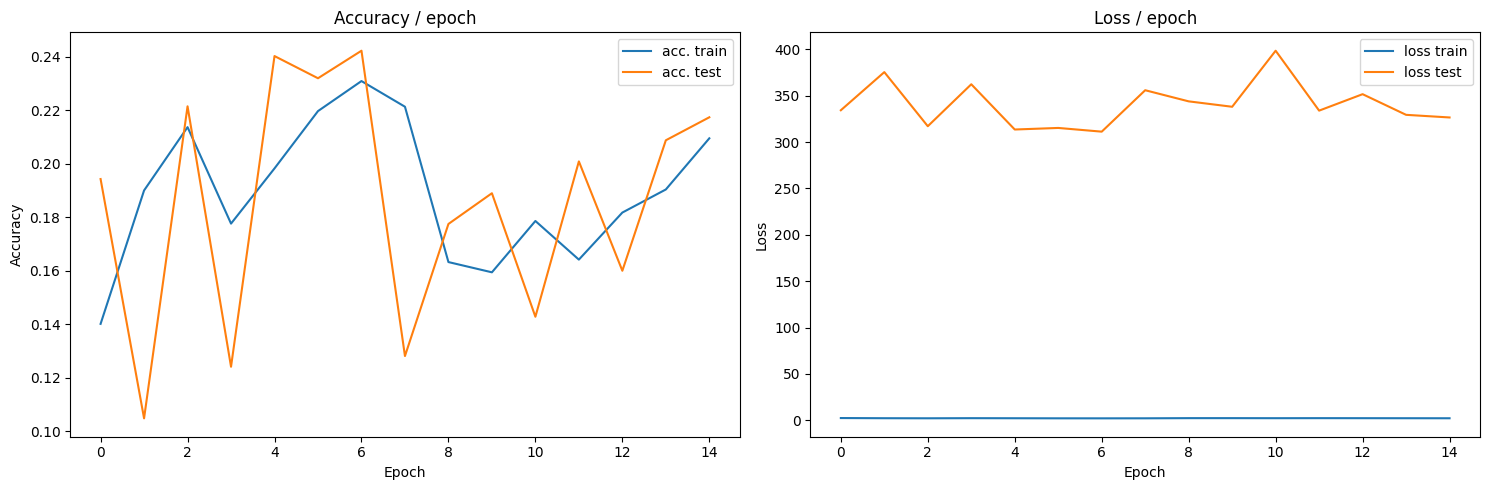

In [35]:
plt.figure(figsize=(15, 5))
# plt.clf()
plt.subplot(1, 2, 1)
plt.plot(np.array(stats_vit[0]), label="acc. train")
plt.plot(np.array(stats_vit[1]), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(stats_vit[2]), label="loss train")
plt.plot(np.array(stats_vit[3]), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("stats_vit.pdf", dpi=100, bbox_inches="tight")
plt.show()

c) redo the training but with the ViT-S pretrained on ImageNet

In [36]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10).cuda()
stats_pretrained = main(model=model, epochs=10, tqdm_batch=True)


  0%|                                                                                                                                                                                 | 0/938 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]


  0%|▏                                                                                                                                                                        | 1/938 [00:00<09:09,  1.70it/s]


  0%|▎                                                                                                                                                                        | 2/938 [00:01<08:51,  1.76it/s]


  0%|▌                                                                                                                                                                        | 3/938 [00:01<08:45,  1.78it/s]


  0%|▋                                                                                                                                                                        | 4/938 [00:02<08:42,  1.79it/s]


  1%|▉                                                                                                                                                                        | 5/938 [00:02<08:57,  1.74it/s]


  1%|█                                                                                                                                                                        | 6/938 [00:03<08:49,  1.76it/s]


  1%|█▎                                                                                                                                                                       | 7/938 [00:03<08:44,  1.78it/s]


  1%|█▍                                                                                                                                                                       | 8/938 [00:04<08:41,  1.78it/s]


  1%|█▌                                                                                                                                                                       | 9/938 [00:05<08:38,  1.79it/s]


  1%|█▊                                                                                                                                                                      | 10/938 [00:05<08:36,  1.80it/s]


  1%|█▉                                                                                                                                                                      | 11/938 [00:06<08:34,  1.80it/s]


  1%|██▏                                                                                                                                                                     | 12/938 [00:06<08:33,  1.80it/s]


  1%|██▎                                                                                                                                                                     | 13/938 [00:07<08:32,  1.80it/s]


  1%|██▌                                                                                                                                                                     | 14/938 [00:07<08:31,  1.80it/s]


  2%|██▋                                                                                                                                                                     | 15/938 [00:08<08:31,  1.80it/s]


  2%|██▊                                                                                                                                                                     | 16/938 [00:08<08:30,  1.81it/s]


  2%|███                                                                                                                                                                     | 17/938 [00:09<08:29,  1.81it/s]


  2%|███▏                                                                                                                                                                    | 18/938 [00:10<08:29,  1.81it/s]


  2%|███▍                                                                                                                                                                    | 19/938 [00:10<08:28,  1.81it/s]


  2%|███▌                                                                                                                                                                    | 20/938 [00:11<08:27,  1.81it/s]


  2%|███▊                                                                                                                                                                    | 21/938 [00:11<08:27,  1.81it/s]


  2%|███▉                                                                                                                                                                    | 22/938 [00:12<08:26,  1.81it/s]


  2%|████                                                                                                                                                                    | 23/938 [00:12<08:26,  1.81it/s]


  3%|████▎                                                                                                                                                                   | 24/938 [00:13<08:25,  1.81it/s]


  3%|████▍                                                                                                                                                                   | 25/938 [00:13<08:25,  1.81it/s]


  3%|████▋                                                                                                                                                                   | 26/938 [00:14<08:24,  1.81it/s]


  3%|████▊                                                                                                                                                                   | 27/938 [00:15<08:24,  1.81it/s]


  3%|█████                                                                                                                                                                   | 28/938 [00:15<08:23,  1.81it/s]


  3%|█████▏                                                                                                                                                                  | 29/938 [00:16<08:23,  1.81it/s]


  3%|█████▎                                                                                                                                                                  | 30/938 [00:16<08:23,  1.80it/s]


  3%|█████▌                                                                                                                                                                  | 31/938 [00:17<08:22,  1.80it/s]


  3%|█████▋                                                                                                                                                                  | 32/938 [00:17<08:21,  1.81it/s]


  4%|█████▉                                                                                                                                                                  | 33/938 [00:18<08:21,  1.81it/s]


  4%|██████                                                                                                                                                                  | 34/938 [00:18<08:21,  1.80it/s]


  4%|██████▎                                                                                                                                                                 | 35/938 [00:19<08:21,  1.80it/s]


  4%|██████▍                                                                                                                                                                 | 36/938 [00:20<08:20,  1.80it/s]


  4%|██████▋                                                                                                                                                                 | 37/938 [00:20<08:19,  1.80it/s]


  4%|██████▊                                                                                                                                                                 | 38/938 [00:21<08:18,  1.80it/s]


  4%|██████▉                                                                                                                                                                 | 39/938 [00:21<08:18,  1.80it/s]


  4%|███████▏                                                                                                                                                                | 40/938 [00:22<08:24,  1.78it/s]


  4%|███████▎                                                                                                                                                                | 41/938 [00:22<08:22,  1.78it/s]


  4%|███████▌                                                                                                                                                                | 42/938 [00:23<08:20,  1.79it/s]


  5%|███████▋                                                                                                                                                                | 43/938 [00:23<08:19,  1.79it/s]


  5%|███████▉                                                                                                                                                                | 44/938 [00:24<08:18,  1.79it/s]


  5%|████████                                                                                                                                                                | 45/938 [00:25<08:17,  1.79it/s]


  5%|████████▏                                                                                                                                                               | 46/938 [00:25<08:17,  1.79it/s]


  5%|████████▍                                                                                                                                                               | 47/938 [00:26<08:15,  1.80it/s]


  5%|████████▌                                                                                                                                                               | 48/938 [00:26<08:15,  1.80it/s]


  5%|████████▊                                                                                                                                                               | 49/938 [00:27<08:15,  1.80it/s]


  5%|████████▉                                                                                                                                                               | 50/938 [00:27<08:18,  1.78it/s]


  5%|█████████▏                                                                                                                                                              | 51/938 [00:28<08:20,  1.77it/s]


  6%|█████████▎                                                                                                                                                              | 52/938 [00:28<08:18,  1.78it/s]


  6%|█████████▍                                                                                                                                                              | 53/938 [00:29<08:16,  1.78it/s]


  6%|█████████▋                                                                                                                                                              | 54/938 [00:30<08:14,  1.79it/s]


  6%|█████████▊                                                                                                                                                              | 55/938 [00:30<08:13,  1.79it/s]


  6%|██████████                                                                                                                                                              | 56/938 [00:31<08:11,  1.79it/s]


  6%|██████████▏                                                                                                                                                             | 57/938 [00:31<08:10,  1.80it/s]


  6%|██████████▍                                                                                                                                                             | 58/938 [00:32<08:10,  1.79it/s]


  6%|██████████▌                                                                                                                                                             | 59/938 [00:32<08:09,  1.79it/s]


  6%|██████████▋                                                                                                                                                             | 60/938 [00:33<08:08,  1.80it/s]


  7%|██████████▉                                                                                                                                                             | 61/938 [00:33<08:08,  1.80it/s]


  7%|███████████                                                                                                                                                             | 62/938 [00:34<08:07,  1.80it/s]


  7%|███████████▎                                                                                                                                                            | 63/938 [00:35<08:07,  1.80it/s]


  7%|███████████▍                                                                                                                                                            | 64/938 [00:35<08:06,  1.80it/s]


  7%|███████████▋                                                                                                                                                            | 65/938 [00:36<08:06,  1.80it/s]


  7%|███████████▊                                                                                                                                                            | 66/938 [00:36<08:05,  1.79it/s]


  7%|████████████                                                                                                                                                            | 67/938 [00:37<08:05,  1.80it/s]


  7%|████████████▏                                                                                                                                                           | 68/938 [00:37<08:04,  1.80it/s]


  7%|████████████▎                                                                                                                                                           | 69/938 [00:38<08:04,  1.80it/s]


  7%|████████████▌                                                                                                                                                           | 70/938 [00:38<08:03,  1.80it/s]


  8%|████████████▋                                                                                                                                                           | 71/938 [00:39<08:02,  1.80it/s]


  8%|████████████▉                                                                                                                                                           | 72/938 [00:40<08:02,  1.79it/s]


  8%|█████████████                                                                                                                                                           | 73/938 [00:40<08:06,  1.78it/s]


  8%|█████████████▎                                                                                                                                                          | 74/938 [00:41<08:03,  1.79it/s]


  8%|█████████████▍                                                                                                                                                          | 75/938 [00:41<08:02,  1.79it/s]


  8%|█████████████▌                                                                                                                                                          | 76/938 [00:42<08:01,  1.79it/s]


  8%|█████████████▊                                                                                                                                                          | 77/938 [00:42<08:00,  1.79it/s]


  8%|█████████████▉                                                                                                                                                          | 78/938 [00:43<07:59,  1.79it/s]


  8%|██████████████▏                                                                                                                                                         | 79/938 [00:44<07:58,  1.79it/s]


  9%|██████████████▎                                                                                                                                                         | 80/938 [00:44<07:58,  1.79it/s]


  9%|██████████████▌                                                                                                                                                         | 81/938 [00:45<07:57,  1.79it/s]


  9%|██████████████▋                                                                                                                                                         | 82/938 [00:45<07:57,  1.79it/s]


  9%|██████████████▊                                                                                                                                                         | 83/938 [00:46<07:55,  1.80it/s]


  9%|███████████████                                                                                                                                                         | 84/938 [00:46<07:55,  1.80it/s]


  9%|███████████████▏                                                                                                                                                        | 85/938 [00:47<07:54,  1.80it/s]


  9%|███████████████▍                                                                                                                                                        | 86/938 [00:47<07:59,  1.78it/s]


  9%|███████████████▌                                                                                                                                                        | 87/938 [00:48<07:57,  1.78it/s]


  9%|███████████████▊                                                                                                                                                        | 88/938 [00:49<07:54,  1.79it/s]


  9%|███████████████▉                                                                                                                                                        | 89/938 [00:49<07:53,  1.79it/s]


 10%|████████████████                                                                                                                                                        | 90/938 [00:50<07:52,  1.80it/s]


 10%|████████████████▎                                                                                                                                                       | 91/938 [00:50<07:51,  1.80it/s]


 10%|████████████████▍                                                                                                                                                       | 92/938 [00:51<07:50,  1.80it/s]


 10%|████████████████▋                                                                                                                                                       | 93/938 [00:51<07:49,  1.80it/s]


 10%|████████████████▊                                                                                                                                                       | 94/938 [00:52<07:49,  1.80it/s]


 10%|█████████████████                                                                                                                                                       | 95/938 [00:52<07:49,  1.80it/s]


 10%|█████████████████▏                                                                                                                                                      | 96/938 [00:53<07:48,  1.80it/s]


 10%|█████████████████▎                                                                                                                                                      | 97/938 [00:54<07:47,  1.80it/s]


 10%|█████████████████▌                                                                                                                                                      | 98/938 [00:54<07:47,  1.80it/s]


 11%|█████████████████▋                                                                                                                                                      | 99/938 [00:55<07:46,  1.80it/s]


 11%|█████████████████▊                                                                                                                                                     | 100/938 [00:55<07:46,  1.80it/s]


 11%|█████████████████▉                                                                                                                                                     | 101/938 [00:56<07:46,  1.79it/s]


 11%|██████████████████▏                                                                                                                                                    | 102/938 [00:56<07:45,  1.80it/s]


 11%|██████████████████▎                                                                                                                                                    | 103/938 [00:57<07:45,  1.79it/s]


 11%|██████████████████▌                                                                                                                                                    | 104/938 [00:57<07:44,  1.79it/s]


 11%|██████████████████▋                                                                                                                                                    | 105/938 [00:58<07:43,  1.80it/s]


 11%|██████████████████▊                                                                                                                                                    | 106/938 [00:59<07:43,  1.80it/s]


 11%|███████████████████                                                                                                                                                    | 107/938 [00:59<07:45,  1.79it/s]


 12%|███████████████████▏                                                                                                                                                   | 108/938 [01:00<07:43,  1.79it/s]


 12%|███████████████████▍                                                                                                                                                   | 109/938 [01:00<07:42,  1.79it/s]


 12%|███████████████████▌                                                                                                                                                   | 110/938 [01:01<07:41,  1.79it/s]


 12%|███████████████████▊                                                                                                                                                   | 111/938 [01:01<07:49,  1.76it/s]


 12%|███████████████████▉                                                                                                                                                   | 112/938 [01:02<07:46,  1.77it/s]


 12%|████████████████████                                                                                                                                                   | 113/938 [01:03<07:44,  1.78it/s]


 12%|████████████████████▎                                                                                                                                                  | 114/938 [01:03<07:41,  1.78it/s]


 12%|████████████████████▍                                                                                                                                                  | 115/938 [01:04<07:40,  1.79it/s]


 12%|████████████████████▋                                                                                                                                                  | 116/938 [01:04<07:39,  1.79it/s]


 12%|████████████████████▊                                                                                                                                                  | 117/938 [01:05<07:38,  1.79it/s]


 13%|█████████████████████                                                                                                                                                  | 118/938 [01:05<07:37,  1.79it/s]


 13%|█████████████████████▏                                                                                                                                                 | 119/938 [01:06<07:37,  1.79it/s]


 13%|█████████████████████▎                                                                                                                                                 | 120/938 [01:06<07:36,  1.79it/s]


 13%|█████████████████████▌                                                                                                                                                 | 121/938 [01:07<07:35,  1.79it/s]


 13%|█████████████████████▋                                                                                                                                                 | 122/938 [01:08<07:34,  1.80it/s]


 13%|█████████████████████▉                                                                                                                                                 | 123/938 [01:08<07:33,  1.80it/s]


 13%|██████████████████████                                                                                                                                                 | 124/938 [01:09<07:33,  1.79it/s]


 13%|██████████████████████▎                                                                                                                                                | 125/938 [01:09<07:32,  1.79it/s]


 13%|██████████████████████▍                                                                                                                                                | 126/938 [01:10<07:37,  1.78it/s]


 14%|██████████████████████▌                                                                                                                                                | 127/938 [01:10<07:35,  1.78it/s]


 14%|██████████████████████▊                                                                                                                                                | 128/938 [01:11<07:33,  1.79it/s]


 14%|██████████████████████▉                                                                                                                                                | 129/938 [01:11<07:32,  1.79it/s]


 14%|███████████████████████▏                                                                                                                                               | 130/938 [01:12<07:31,  1.79it/s]


 14%|███████████████████████▎                                                                                                                                               | 131/938 [01:13<07:30,  1.79it/s]


 14%|███████████████████████▌                                                                                                                                               | 132/938 [01:13<07:30,  1.79it/s]


 14%|███████████████████████▋                                                                                                                                               | 133/938 [01:14<07:29,  1.79it/s]


 14%|███████████████████████▊                                                                                                                                               | 134/938 [01:14<07:28,  1.79it/s]


 14%|████████████████████████                                                                                                                                               | 135/938 [01:15<07:27,  1.79it/s]


 14%|████████████████████████▏                                                                                                                                              | 136/938 [01:15<07:27,  1.79it/s]


 15%|████████████████████████▍                                                                                                                                              | 137/938 [01:16<07:26,  1.79it/s]


 15%|████████████████████████▌                                                                                                                                              | 138/938 [01:16<07:25,  1.80it/s]


 15%|████████████████████████▋                                                                                                                                              | 139/938 [01:17<07:25,  1.79it/s]


 15%|████████████████████████▉                                                                                                                                              | 140/938 [01:18<07:25,  1.79it/s]


 15%|█████████████████████████                                                                                                                                              | 141/938 [01:18<07:24,  1.79it/s]


 15%|█████████████████████████▎                                                                                                                                             | 142/938 [01:19<07:24,  1.79it/s]


 15%|█████████████████████████▍                                                                                                                                             | 143/938 [01:19<07:24,  1.79it/s]


 15%|█████████████████████████▋                                                                                                                                             | 144/938 [01:20<07:23,  1.79it/s]


 15%|█████████████████████████▊                                                                                                                                             | 145/938 [01:20<07:22,  1.79it/s]


 16%|█████████████████████████▉                                                                                                                                             | 146/938 [01:21<07:22,  1.79it/s]


 16%|██████████████████████████▏                                                                                                                                            | 147/938 [01:21<07:21,  1.79it/s]


 16%|██████████████████████████▎                                                                                                                                            | 148/938 [01:22<07:20,  1.79it/s]


 16%|██████████████████████████▌                                                                                                                                            | 149/938 [01:23<07:23,  1.78it/s]


 16%|██████████████████████████▋                                                                                                                                            | 150/938 [01:23<07:21,  1.79it/s]


 16%|██████████████████████████▉                                                                                                                                            | 151/938 [01:24<07:19,  1.79it/s]


 16%|███████████████████████████                                                                                                                                            | 152/938 [01:24<07:18,  1.79it/s]


 16%|███████████████████████████▏                                                                                                                                           | 153/938 [01:25<07:17,  1.80it/s]


 16%|███████████████████████████▍                                                                                                                                           | 154/938 [01:25<07:16,  1.80it/s]


 17%|███████████████████████████▌                                                                                                                                           | 155/938 [01:26<07:18,  1.79it/s]


 17%|███████████████████████████▊                                                                                                                                           | 156/938 [01:27<07:16,  1.79it/s]


 17%|███████████████████████████▉                                                                                                                                           | 157/938 [01:27<07:15,  1.79it/s]


 17%|████████████████████████████▏                                                                                                                                          | 158/938 [01:28<07:14,  1.79it/s]


 17%|████████████████████████████▎                                                                                                                                          | 159/938 [01:28<07:14,  1.79it/s]


 17%|████████████████████████████▍                                                                                                                                          | 160/938 [01:29<07:13,  1.80it/s]


 17%|████████████████████████████▋                                                                                                                                          | 161/938 [01:29<07:12,  1.79it/s]


 17%|████████████████████████████▊                                                                                                                                          | 162/938 [01:30<07:12,  1.79it/s]


 17%|█████████████████████████████                                                                                                                                          | 163/938 [01:30<07:11,  1.79it/s]


 17%|█████████████████████████████▏                                                                                                                                         | 164/938 [01:31<07:11,  1.79it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 165/938 [01:32<07:10,  1.79it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 166/938 [01:32<07:10,  1.79it/s]


 18%|█████████████████████████████▋                                                                                                                                         | 167/938 [01:33<07:09,  1.80it/s]


 18%|█████████████████████████████▉                                                                                                                                         | 168/938 [01:33<07:08,  1.80it/s]


 18%|██████████████████████████████                                                                                                                                         | 169/938 [01:34<07:08,  1.80it/s]


 18%|██████████████████████████████▎                                                                                                                                        | 170/938 [01:34<07:07,  1.80it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 171/938 [01:35<07:07,  1.79it/s]


 18%|██████████████████████████████▌                                                                                                                                        | 172/938 [01:35<07:06,  1.79it/s]


 18%|██████████████████████████████▊                                                                                                                                        | 173/938 [01:36<07:06,  1.79it/s]


 19%|██████████████████████████████▉                                                                                                                                        | 174/938 [01:37<07:05,  1.79it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 175/938 [01:37<07:04,  1.80it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 176/938 [01:38<07:04,  1.80it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 177/938 [01:38<07:03,  1.80it/s]


 19%|███████████████████████████████▋                                                                                                                                       | 178/938 [01:39<07:02,  1.80it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 179/938 [01:39<07:01,  1.80it/s]


 19%|████████████████████████████████                                                                                                                                       | 180/938 [01:40<07:00,  1.80it/s]


 19%|████████████████████████████████▏                                                                                                                                      | 181/938 [01:40<07:00,  1.80it/s]


 19%|████████████████████████████████▍                                                                                                                                      | 182/938 [01:41<06:59,  1.80it/s]


 20%|████████████████████████████████▌                                                                                                                                      | 183/938 [01:42<06:59,  1.80it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 184/938 [01:42<06:58,  1.80it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 185/938 [01:43<06:58,  1.80it/s]


 20%|█████████████████████████████████                                                                                                                                      | 186/938 [01:43<06:57,  1.80it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 187/938 [01:44<06:56,  1.80it/s]


 20%|█████████████████████████████████▍                                                                                                                                     | 188/938 [01:44<07:01,  1.78it/s]


 20%|█████████████████████████████████▋                                                                                                                                     | 189/938 [01:45<06:59,  1.79it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 190/938 [01:45<06:57,  1.79it/s]


 20%|██████████████████████████████████                                                                                                                                     | 191/938 [01:46<06:56,  1.79it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 192/938 [01:47<06:55,  1.79it/s]


 21%|██████████████████████████████████▎                                                                                                                                    | 193/938 [01:47<06:54,  1.80it/s]


 21%|██████████████████████████████████▌                                                                                                                                    | 194/938 [01:48<06:53,  1.80it/s]


 21%|██████████████████████████████████▋                                                                                                                                    | 195/938 [01:48<06:52,  1.80it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 196/938 [01:49<06:52,  1.80it/s]


 21%|███████████████████████████████████                                                                                                                                    | 197/938 [01:49<06:51,  1.80it/s]


 21%|███████████████████████████████████▎                                                                                                                                   | 198/938 [01:50<06:50,  1.80it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 199/938 [01:50<06:50,  1.80it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 200/938 [01:51<06:49,  1.80it/s]


 21%|███████████████████████████████████▊                                                                                                                                   | 201/938 [01:52<06:49,  1.80it/s]


 22%|███████████████████████████████████▉                                                                                                                                   | 202/938 [01:52<06:48,  1.80it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 203/938 [01:53<06:48,  1.80it/s]


 22%|████████████████████████████████████▎                                                                                                                                  | 204/938 [01:53<06:54,  1.77it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 205/938 [01:54<06:51,  1.78it/s]


 22%|████████████████████████████████████▋                                                                                                                                  | 206/938 [01:54<06:49,  1.79it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 207/938 [01:55<06:48,  1.79it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 208/938 [01:55<06:46,  1.79it/s]


 22%|█████████████████████████████████████▏                                                                                                                                 | 209/938 [01:56<06:45,  1.80it/s]


 22%|█████████████████████████████████████▍                                                                                                                                 | 210/938 [01:57<06:44,  1.80it/s]


 22%|█████████████████████████████████████▌                                                                                                                                 | 211/938 [01:57<06:44,  1.80it/s]


 23%|█████████████████████████████████████▋                                                                                                                                 | 212/938 [01:58<06:43,  1.80it/s]


 23%|█████████████████████████████████████▉                                                                                                                                 | 213/938 [01:58<06:42,  1.80it/s]


 23%|██████████████████████████████████████                                                                                                                                 | 214/938 [01:59<06:42,  1.80it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 215/938 [01:59<06:41,  1.80it/s]


 23%|██████████████████████████████████████▍                                                                                                                                | 216/938 [02:00<06:40,  1.80it/s]


 23%|██████████████████████████████████████▋                                                                                                                                | 217/938 [02:00<06:40,  1.80it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 218/938 [02:01<06:40,  1.80it/s]


 23%|██████████████████████████████████████▉                                                                                                                                | 219/938 [02:02<06:40,  1.80it/s]


 23%|███████████████████████████████████████▏                                                                                                                               | 220/938 [02:02<06:39,  1.80it/s]


 24%|███████████████████████████████████████▎                                                                                                                               | 221/938 [02:03<06:39,  1.80it/s]


 24%|███████████████████████████████████████▌                                                                                                                               | 222/938 [02:03<06:38,  1.80it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 223/938 [02:04<06:37,  1.80it/s]


 24%|███████████████████████████████████████▉                                                                                                                               | 224/938 [02:04<06:36,  1.80it/s]


 24%|████████████████████████████████████████                                                                                                                               | 225/938 [02:05<06:36,  1.80it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 226/938 [02:05<06:35,  1.80it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 227/938 [02:06<06:34,  1.80it/s]


 24%|████████████████████████████████████████▌                                                                                                                              | 228/938 [02:07<06:37,  1.79it/s]


 24%|████████████████████████████████████████▊                                                                                                                              | 229/938 [02:07<06:43,  1.76it/s]


 25%|████████████████████████████████████████▉                                                                                                                              | 230/938 [02:08<06:40,  1.77it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 231/938 [02:08<06:37,  1.78it/s]


 25%|█████████████████████████████████████████▎                                                                                                                             | 232/938 [02:09<06:35,  1.79it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 233/938 [02:09<06:33,  1.79it/s]


 25%|█████████████████████████████████████████▋                                                                                                                             | 234/938 [02:10<06:32,  1.79it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 235/938 [02:11<06:31,  1.80it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 236/938 [02:11<06:31,  1.80it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 237/938 [02:12<06:30,  1.79it/s]


 25%|██████████████████████████████████████████▎                                                                                                                            | 238/938 [02:12<06:29,  1.80it/s]


 25%|██████████████████████████████████████████▌                                                                                                                            | 239/938 [02:13<06:29,  1.80it/s]


 26%|██████████████████████████████████████████▋                                                                                                                            | 240/938 [02:13<06:28,  1.80it/s]


 26%|██████████████████████████████████████████▉                                                                                                                            | 241/938 [02:14<06:27,  1.80it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 242/938 [02:14<06:27,  1.80it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 243/938 [02:15<06:27,  1.80it/s]


 26%|███████████████████████████████████████████▍                                                                                                                           | 244/938 [02:16<06:26,  1.80it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 245/938 [02:16<06:26,  1.80it/s]


 26%|███████████████████████████████████████████▊                                                                                                                           | 246/938 [02:17<06:25,  1.80it/s]


 26%|███████████████████████████████████████████▉                                                                                                                           | 247/938 [02:17<06:24,  1.80it/s]


 26%|████████████████████████████████████████████▏                                                                                                                          | 248/938 [02:18<06:23,  1.80it/s]


 27%|████████████████████████████████████████████▎                                                                                                                          | 249/938 [02:18<06:23,  1.80it/s]


 27%|████████████████████████████████████████████▌                                                                                                                          | 250/938 [02:19<06:23,  1.79it/s]


 27%|████████████████████████████████████████████▋                                                                                                                          | 251/938 [02:19<06:23,  1.79it/s]


 27%|████████████████████████████████████████████▊                                                                                                                          | 252/938 [02:20<06:22,  1.79it/s]


 27%|█████████████████████████████████████████████                                                                                                                          | 253/938 [02:21<06:27,  1.77it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 254/938 [02:21<06:28,  1.76it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 255/938 [02:22<06:25,  1.77it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                         | 256/938 [02:22<06:23,  1.78it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 257/938 [02:23<06:21,  1.78it/s]


 28%|█████████████████████████████████████████████▉                                                                                                                         | 258/938 [02:23<06:20,  1.79it/s]


 28%|██████████████████████████████████████████████                                                                                                                         | 259/938 [02:24<06:19,  1.79it/s]


 28%|██████████████████████████████████████████████▎                                                                                                                        | 260/938 [02:24<06:18,  1.79it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 261/938 [02:25<06:17,  1.79it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                        | 262/938 [02:26<06:16,  1.79it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                        | 263/938 [02:26<06:15,  1.80it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 264/938 [02:27<06:15,  1.80it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                       | 265/938 [02:27<06:14,  1.80it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                       | 266/938 [02:28<06:13,  1.80it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                       | 267/938 [02:28<06:17,  1.78it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 268/938 [02:29<06:19,  1.77it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                       | 269/938 [02:30<06:16,  1.78it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 270/938 [02:30<06:15,  1.78it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 271/938 [02:31<06:13,  1.79it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                      | 272/938 [02:31<06:21,  1.74it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 273/938 [02:32<06:17,  1.76it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 274/938 [02:32<06:14,  1.77it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                      | 275/938 [02:33<06:11,  1.78it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                     | 276/938 [02:33<06:09,  1.79it/s]


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 277/938 [02:34<06:08,  1.79it/s]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 278/938 [02:35<06:07,  1.80it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 279/938 [02:35<06:06,  1.80it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 280/938 [02:36<06:06,  1.80it/s]


 30%|██████████████████████████████████████████████████                                                                                                                     | 281/938 [02:36<06:05,  1.80it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 282/938 [02:37<06:05,  1.80it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                    | 283/938 [02:37<06:04,  1.80it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                    | 284/938 [02:38<06:03,  1.80it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                    | 285/938 [02:38<06:03,  1.80it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                    | 286/938 [02:39<06:05,  1.79it/s]


 31%|███████████████████████████████████████████████████                                                                                                                    | 287/938 [02:40<06:03,  1.79it/s]


 31%|███████████████████████████████████████████████████▎                                                                                                                   | 288/938 [02:40<06:02,  1.79it/s]


 31%|███████████████████████████████████████████████████▍                                                                                                                   | 289/938 [02:41<06:01,  1.79it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                   | 290/938 [02:41<06:01,  1.79it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                   | 291/938 [02:42<06:00,  1.79it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                   | 292/938 [02:42<06:00,  1.79it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                  | 293/938 [02:43<05:59,  1.80it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                  | 294/938 [02:43<05:58,  1.80it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                  | 295/938 [02:44<05:57,  1.80it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                  | 296/938 [02:45<05:57,  1.80it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                  | 297/938 [02:45<05:56,  1.80it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                  | 298/938 [02:46<05:56,  1.80it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                 | 299/938 [02:46<05:55,  1.80it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 300/938 [02:47<05:54,  1.80it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                 | 301/938 [02:47<05:54,  1.80it/s]


 32%|█████████████████████████████████████████████████████▊                                                                                                                 | 302/938 [02:48<05:54,  1.79it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                 | 303/938 [02:49<05:53,  1.79it/s]


 32%|██████████████████████████████████████████████████████                                                                                                                 | 304/938 [02:49<05:53,  1.79it/s]


 33%|██████████████████████████████████████████████████████▎                                                                                                                | 305/938 [02:50<05:53,  1.79it/s]


 33%|██████████████████████████████████████████████████████▍                                                                                                                | 306/938 [02:50<05:52,  1.79it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                                | 307/938 [02:51<05:51,  1.79it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                                | 308/938 [02:51<05:51,  1.79it/s]


 33%|███████████████████████████████████████████████████████                                                                                                                | 309/938 [02:52<05:54,  1.77it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                               | 310/938 [02:52<05:52,  1.78it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                               | 311/938 [02:53<05:51,  1.79it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                               | 312/938 [02:54<05:49,  1.79it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 313/938 [02:54<05:48,  1.79it/s]


 33%|███████████████████████████████████████████████████████▉                                                                                                               | 314/938 [02:55<05:47,  1.80it/s]


 34%|████████████████████████████████████████████████████████                                                                                                               | 315/938 [02:55<05:46,  1.80it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                              | 316/938 [02:56<05:45,  1.80it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                              | 317/938 [02:56<05:44,  1.80it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                              | 318/938 [02:57<05:44,  1.80it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                              | 319/938 [02:57<05:43,  1.80it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                              | 320/938 [02:58<05:42,  1.80it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                             | 321/938 [02:59<05:42,  1.80it/s]


 34%|█████████████████████████████████████████████████████████▎                                                                                                             | 322/938 [02:59<05:41,  1.80it/s]


 34%|█████████████████████████████████████████████████████████▌                                                                                                             | 323/938 [03:00<05:41,  1.80it/s]


 35%|█████████████████████████████████████████████████████████▋                                                                                                             | 324/938 [03:00<05:40,  1.80it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                             | 325/938 [03:01<05:40,  1.80it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                             | 326/938 [03:01<05:39,  1.80it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                            | 327/938 [03:02<05:38,  1.80it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                            | 328/938 [03:02<05:38,  1.80it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                            | 329/938 [03:03<05:37,  1.80it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                            | 330/938 [03:04<05:37,  1.80it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 331/938 [03:04<05:36,  1.80it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                            | 332/938 [03:05<05:35,  1.80it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                           | 333/938 [03:05<05:35,  1.80it/s]


 36%|███████████████████████████████████████████████████████████▍                                                                                                           | 334/938 [03:06<05:35,  1.80it/s]


 36%|███████████████████████████████████████████████████████████▋                                                                                                           | 335/938 [03:06<05:34,  1.80it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                           | 336/938 [03:07<05:33,  1.80it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                           | 337/938 [03:07<05:33,  1.80it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                          | 338/938 [03:08<05:32,  1.80it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                          | 339/938 [03:09<05:32,  1.80it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                          | 340/938 [03:09<05:31,  1.80it/s]


 36%|████████████████████████████████████████████████████████████▋                                                                                                          | 341/938 [03:10<05:30,  1.80it/s]


 36%|████████████████████████████████████████████████████████████▉                                                                                                          | 342/938 [03:10<05:30,  1.80it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                          | 343/938 [03:11<05:30,  1.80it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                         | 344/938 [03:11<05:30,  1.80it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                         | 345/938 [03:12<05:29,  1.80it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 346/938 [03:12<05:28,  1.80it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                         | 347/938 [03:13<05:28,  1.80it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                         | 348/938 [03:14<05:28,  1.80it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 349/938 [03:14<05:29,  1.79it/s]


 37%|██████████████████████████████████████████████████████████████▎                                                                                                        | 350/938 [03:15<05:28,  1.79it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                        | 351/938 [03:15<05:30,  1.78it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 352/938 [03:16<05:28,  1.79it/s]


 38%|██████████████████████████████████████████████████████████████▊                                                                                                        | 353/938 [03:16<05:26,  1.79it/s]


 38%|███████████████████████████████████████████████████████████████                                                                                                        | 354/938 [03:17<05:25,  1.80it/s]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                       | 355/938 [03:17<05:24,  1.80it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                       | 356/938 [03:18<05:23,  1.80it/s]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                       | 357/938 [03:19<05:25,  1.79it/s]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                       | 358/938 [03:19<05:29,  1.76it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                       | 359/938 [03:20<05:26,  1.77it/s]


 38%|████████████████████████████████████████████████████████████████                                                                                                       | 360/938 [03:20<05:24,  1.78it/s]


 38%|████████████████████████████████████████████████████████████████▎                                                                                                      | 361/938 [03:21<05:22,  1.79it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                      | 362/938 [03:21<05:21,  1.79it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                      | 363/938 [03:22<05:20,  1.80it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                      | 364/938 [03:22<05:19,  1.80it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                      | 365/938 [03:23<05:18,  1.80it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                     | 366/938 [03:24<05:17,  1.80it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                     | 367/938 [03:24<05:16,  1.80it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                     | 368/938 [03:25<05:16,  1.80it/s]


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                     | 369/938 [03:25<05:15,  1.80it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                     | 370/938 [03:26<05:15,  1.80it/s]


 40%|██████████████████████████████████████████████████████████████████                                                                                                     | 371/938 [03:26<05:14,  1.80it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                    | 372/938 [03:27<05:13,  1.80it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 373/938 [03:27<05:13,  1.80it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                    | 374/938 [03:28<05:12,  1.80it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 375/938 [03:29<05:12,  1.80it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                    | 376/938 [03:29<05:11,  1.80it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                    | 377/938 [03:30<05:11,  1.80it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                   | 378/938 [03:30<05:10,  1.80it/s]


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                   | 379/938 [03:31<05:10,  1.80it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                   | 380/938 [03:31<05:09,  1.80it/s]


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                   | 381/938 [03:32<05:09,  1.80it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                   | 382/938 [03:32<05:08,  1.80it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                  | 383/938 [03:33<05:11,  1.78it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                  | 384/938 [03:34<05:09,  1.79it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                  | 385/938 [03:34<05:08,  1.79it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                  | 386/938 [03:35<05:07,  1.80it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                  | 387/938 [03:35<05:06,  1.80it/s]


 41%|█████████████████████████████████████████████████████████████████████                                                                                                  | 388/938 [03:36<05:05,  1.80it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                 | 389/938 [03:36<05:04,  1.80it/s]


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                 | 390/938 [03:37<05:04,  1.80it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                 | 391/938 [03:37<05:03,  1.80it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                 | 392/938 [03:38<05:02,  1.80it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                 | 393/938 [03:39<05:02,  1.80it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                | 394/938 [03:39<05:01,  1.80it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                | 395/938 [03:40<05:01,  1.80it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 396/938 [03:40<05:07,  1.77it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                | 397/938 [03:41<05:04,  1.78it/s]


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                | 398/938 [03:41<05:02,  1.78it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                                | 399/938 [03:42<05:02,  1.78it/s]


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                               | 400/938 [03:43<05:01,  1.79it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                               | 401/938 [03:43<04:59,  1.79it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 402/938 [03:44<04:58,  1.80it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                               | 403/938 [03:44<04:57,  1.80it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                               | 404/938 [03:45<04:56,  1.80it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 405/938 [03:45<04:55,  1.80it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                              | 406/938 [03:46<04:55,  1.80it/s]


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                              | 407/938 [03:46<04:54,  1.80it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                              | 408/938 [03:47<04:54,  1.80it/s]


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                              | 409/938 [03:47<04:53,  1.80it/s]


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                              | 410/938 [03:48<04:53,  1.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                             | 411/938 [03:49<04:52,  1.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                             | 412/938 [03:49<04:51,  1.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                             | 413/938 [03:50<04:51,  1.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                             | 414/938 [03:50<04:50,  1.80it/s]


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                             | 415/938 [03:51<04:50,  1.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                             | 416/938 [03:51<04:49,  1.80it/s]


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                            | 417/938 [03:52<04:49,  1.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                            | 418/938 [03:52<04:48,  1.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                            | 419/938 [03:53<04:48,  1.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                            | 420/938 [03:54<04:47,  1.80it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                            | 421/938 [03:54<04:46,  1.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                           | 422/938 [03:55<04:46,  1.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 423/938 [03:55<04:45,  1.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                           | 424/938 [03:56<04:45,  1.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                           | 425/938 [03:56<04:44,  1.80it/s]


 45%|███████████████████████████████████████████████████████████████████████████▊                                                                                           | 426/938 [03:57<04:44,  1.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                           | 427/938 [03:57<04:43,  1.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                          | 428/938 [03:58<04:42,  1.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                          | 429/938 [03:59<04:42,  1.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                          | 430/938 [03:59<04:41,  1.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                          | 431/938 [04:00<04:41,  1.80it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                          | 432/938 [04:00<04:40,  1.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                          | 433/938 [04:01<04:42,  1.78it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                         | 434/938 [04:01<04:41,  1.79it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                         | 435/938 [04:02<04:40,  1.79it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                         | 436/938 [04:02<04:39,  1.80it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                         | 437/938 [04:03<04:38,  1.80it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                         | 438/938 [04:04<04:37,  1.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                        | 439/938 [04:04<04:37,  1.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                        | 440/938 [04:05<04:36,  1.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 441/938 [04:05<04:35,  1.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                        | 442/938 [04:06<04:35,  1.80it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                        | 443/938 [04:06<04:34,  1.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                        | 444/938 [04:07<04:34,  1.80it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                       | 445/938 [04:08<04:43,  1.74it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                       | 446/938 [04:08<04:39,  1.76it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                       | 447/938 [04:09<04:37,  1.77it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                       | 448/938 [04:09<04:38,  1.76it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                       | 449/938 [04:10<04:35,  1.77it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                       | 450/938 [04:10<04:33,  1.78it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 451/938 [04:11<04:32,  1.79it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 452/938 [04:11<04:31,  1.79it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 453/938 [04:12<04:29,  1.80it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 454/938 [04:13<04:29,  1.80it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                      | 455/938 [04:13<04:28,  1.80it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 456/938 [04:14<04:27,  1.80it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 457/938 [04:14<04:26,  1.80it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 458/938 [04:15<04:29,  1.78it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 459/938 [04:15<04:27,  1.79it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 460/938 [04:16<04:26,  1.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                     | 461/938 [04:16<04:25,  1.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 462/938 [04:17<04:24,  1.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 463/938 [04:18<04:24,  1.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 464/938 [04:18<04:24,  1.79it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 465/938 [04:19<04:23,  1.79it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 466/938 [04:19<04:23,  1.79it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 467/938 [04:20<04:24,  1.78it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 468/938 [04:20<04:23,  1.79it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 469/938 [04:21<04:22,  1.79it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 470/938 [04:21<04:21,  1.79it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 471/938 [04:22<04:20,  1.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                   | 472/938 [04:23<04:19,  1.79it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 473/938 [04:23<04:19,  1.80it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 474/938 [04:24<04:20,  1.78it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 475/938 [04:24<04:19,  1.78it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 476/938 [04:25<04:18,  1.79it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 477/938 [04:25<04:17,  1.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                  | 478/938 [04:26<04:16,  1.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 479/938 [04:27<04:15,  1.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 480/938 [04:27<04:15,  1.79it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 481/938 [04:28<04:14,  1.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 482/938 [04:28<04:13,  1.80it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 483/938 [04:29<04:13,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 484/938 [04:29<04:12,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 485/938 [04:30<04:12,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 486/938 [04:30<04:11,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 487/938 [04:31<04:11,  1.80it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 488/938 [04:32<04:10,  1.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                | 489/938 [04:32<04:09,  1.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 490/938 [04:33<04:09,  1.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 491/938 [04:33<04:08,  1.80it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 492/938 [04:34<04:08,  1.80it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 493/938 [04:34<04:07,  1.80it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 494/938 [04:35<04:06,  1.80it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 495/938 [04:35<04:06,  1.80it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 496/938 [04:36<04:05,  1.80it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 497/938 [04:37<04:04,  1.80it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 498/938 [04:37<04:04,  1.80it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 499/938 [04:38<04:03,  1.80it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                              | 500/938 [04:38<04:03,  1.80it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 501/938 [04:39<04:02,  1.80it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 502/938 [04:39<04:02,  1.80it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 503/938 [04:40<04:01,  1.80it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 504/938 [04:40<04:01,  1.80it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 505/938 [04:41<04:00,  1.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                             | 506/938 [04:42<03:59,  1.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 507/938 [04:42<03:59,  1.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 508/938 [04:43<03:58,  1.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 509/938 [04:43<03:58,  1.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 510/938 [04:44<03:57,  1.80it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 511/938 [04:44<03:57,  1.80it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 512/938 [04:45<03:56,  1.80it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 513/938 [04:45<03:56,  1.80it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 514/938 [04:46<03:55,  1.80it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 515/938 [04:47<03:54,  1.80it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 516/938 [04:47<03:54,  1.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 517/938 [04:48<03:53,  1.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 518/938 [04:48<03:53,  1.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 519/938 [04:49<03:52,  1.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 520/938 [04:49<03:52,  1.80it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 521/938 [04:50<03:51,  1.80it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 522/938 [04:50<03:50,  1.80it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 523/938 [04:51<03:50,  1.80it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 524/938 [04:52<03:49,  1.80it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 525/938 [04:52<03:49,  1.80it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 526/938 [04:53<03:48,  1.80it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 527/938 [04:53<03:53,  1.76it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 528/938 [04:54<03:53,  1.76it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 529/938 [04:54<03:52,  1.76it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 530/938 [04:55<03:52,  1.76it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 531/938 [04:56<03:52,  1.75it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 532/938 [04:56<03:51,  1.75it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 533/938 [04:57<03:50,  1.75it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 534/938 [04:57<03:50,  1.75it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 535/938 [04:58<03:49,  1.75it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 536/938 [04:58<03:47,  1.77it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 537/938 [04:59<03:45,  1.78it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 538/938 [04:59<03:43,  1.79it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 539/938 [05:00<03:42,  1.79it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 540/938 [05:01<03:41,  1.79it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 541/938 [05:01<03:44,  1.77it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 542/938 [05:02<03:42,  1.78it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 543/938 [05:02<03:41,  1.79it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 544/938 [05:03<03:39,  1.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 545/938 [05:03<03:38,  1.79it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 546/938 [05:04<03:38,  1.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 547/938 [05:04<03:37,  1.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 548/938 [05:05<03:36,  1.80it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 549/938 [05:06<03:35,  1.80it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 550/938 [05:06<03:35,  1.80it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 551/938 [05:07<03:34,  1.80it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 552/938 [05:07<03:34,  1.80it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 553/938 [05:08<03:34,  1.79it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 554/938 [05:08<03:33,  1.80it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 555/938 [05:09<03:33,  1.79it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 556/938 [05:09<03:33,  1.79it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 557/938 [05:10<03:32,  1.80it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 558/938 [05:11<03:31,  1.80it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 559/938 [05:11<03:30,  1.80it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 560/938 [05:12<03:29,  1.80it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 561/938 [05:12<03:29,  1.80it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 562/938 [05:13<03:28,  1.80it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 563/938 [05:13<03:28,  1.80it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 564/938 [05:14<03:27,  1.80it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 565/938 [05:14<03:27,  1.80it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 566/938 [05:15<03:28,  1.78it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 567/938 [05:16<03:27,  1.79it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 568/938 [05:16<03:31,  1.75it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 569/938 [05:17<03:29,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 570/938 [05:17<03:27,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 571/938 [05:18<03:26,  1.78it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 572/938 [05:18<03:25,  1.78it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 573/938 [05:19<03:24,  1.78it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 574/938 [05:20<03:23,  1.79it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 575/938 [05:20<03:22,  1.79it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 576/938 [05:21<03:22,  1.79it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 577/938 [05:21<03:21,  1.79it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 578/938 [05:22<03:20,  1.79it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 579/938 [05:22<03:20,  1.79it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 580/938 [05:23<03:19,  1.79it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 581/938 [05:23<03:19,  1.79it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 582/938 [05:24<03:18,  1.79it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 583/938 [05:25<03:18,  1.79it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 584/938 [05:25<03:17,  1.79it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 585/938 [05:26<03:16,  1.79it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 586/938 [05:26<03:16,  1.79it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 587/938 [05:27<03:15,  1.79it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 588/938 [05:27<03:15,  1.79it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 589/938 [05:28<03:14,  1.79it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 590/938 [05:28<03:14,  1.79it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/938 [05:29<03:14,  1.79it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 592/938 [05:30<03:13,  1.79it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 593/938 [05:30<03:12,  1.79it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 594/938 [05:31<03:12,  1.79it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 595/938 [05:31<03:11,  1.79it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/938 [05:32<03:10,  1.79it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 597/938 [05:32<03:10,  1.79it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 598/938 [05:33<03:09,  1.79it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 599/938 [05:33<03:08,  1.79it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 600/938 [05:34<03:08,  1.80it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 601/938 [05:35<03:07,  1.80it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 602/938 [05:35<03:06,  1.80it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 603/938 [05:36<03:06,  1.80it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 604/938 [05:36<03:05,  1.80it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 605/938 [05:37<03:05,  1.80it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 606/938 [05:37<03:04,  1.80it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 607/938 [05:38<03:03,  1.80it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 608/938 [05:38<03:03,  1.80it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 609/938 [05:39<03:02,  1.80it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 610/938 [05:40<03:02,  1.80it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 611/938 [05:40<03:01,  1.80it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 612/938 [05:41<03:01,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 613/938 [05:41<03:00,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 614/938 [05:42<02:59,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 615/938 [05:42<02:59,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 616/938 [05:43<02:58,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 617/938 [05:44<02:59,  1.79it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 618/938 [05:44<02:58,  1.79it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 619/938 [05:45<02:57,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 620/938 [05:45<02:56,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 621/938 [05:46<02:56,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 622/938 [05:46<02:55,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 623/938 [05:47<02:55,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 624/938 [05:47<02:54,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 625/938 [05:48<02:53,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 626/938 [05:49<02:53,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 627/938 [05:49<02:52,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 628/938 [05:50<02:53,  1.79it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 629/938 [05:50<02:53,  1.78it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 630/938 [05:51<02:53,  1.77it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 631/938 [05:51<02:52,  1.78it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 632/938 [05:52<02:51,  1.79it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 633/938 [05:52<02:50,  1.79it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 634/938 [05:53<02:49,  1.79it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 635/938 [05:54<02:48,  1.79it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 636/938 [05:54<02:48,  1.79it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 637/938 [05:55<02:47,  1.79it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 638/938 [05:55<02:47,  1.79it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 639/938 [05:56<02:46,  1.79it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 640/938 [05:56<02:46,  1.79it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 641/938 [05:57<02:45,  1.80it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 642/938 [05:57<02:44,  1.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 643/938 [05:58<02:44,  1.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 644/938 [05:59<02:43,  1.79it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 645/938 [05:59<02:43,  1.80it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 646/938 [06:00<02:43,  1.79it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 647/938 [06:00<02:42,  1.79it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 648/938 [06:01<02:41,  1.79it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 649/938 [06:01<02:40,  1.80it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 650/938 [06:02<02:40,  1.80it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 651/938 [06:02<02:39,  1.80it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 652/938 [06:03<02:38,  1.80it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 653/938 [06:04<02:38,  1.80it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 654/938 [06:04<02:37,  1.80it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 655/938 [06:05<02:37,  1.80it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 656/938 [06:05<02:38,  1.78it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 657/938 [06:06<02:36,  1.79it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 658/938 [06:06<02:36,  1.79it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 659/938 [06:07<02:35,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 660/938 [06:07<02:34,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 661/938 [06:08<02:33,  1.80it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 662/938 [06:09<02:33,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 663/938 [06:09<02:32,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 664/938 [06:10<02:32,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 665/938 [06:10<02:31,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 666/938 [06:11<02:31,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 667/938 [06:11<02:30,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 668/938 [06:12<02:30,  1.80it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 669/938 [06:12<02:29,  1.80it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 670/938 [06:13<02:28,  1.80it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 671/938 [06:14<02:28,  1.80it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 672/938 [06:14<02:27,  1.80it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 673/938 [06:15<02:27,  1.80it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 674/938 [06:15<02:26,  1.80it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 675/938 [06:16<02:25,  1.80it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 676/938 [06:16<02:25,  1.80it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 677/938 [06:17<02:24,  1.80it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 678/938 [06:17<02:24,  1.80it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 679/938 [06:18<02:23,  1.80it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 680/938 [06:19<02:23,  1.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 681/938 [06:19<02:23,  1.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 682/938 [06:20<02:22,  1.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 683/938 [06:20<02:21,  1.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 684/938 [06:21<02:21,  1.80it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 685/938 [06:21<02:20,  1.80it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 686/938 [06:22<02:20,  1.80it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 687/938 [06:22<02:19,  1.80it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 688/938 [06:23<02:18,  1.80it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 689/938 [06:24<02:18,  1.80it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 690/938 [06:24<02:17,  1.80it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 691/938 [06:25<02:17,  1.80it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 692/938 [06:25<02:17,  1.79it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 693/938 [06:26<02:16,  1.79it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 694/938 [06:26<02:15,  1.80it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 695/938 [06:27<02:15,  1.80it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 696/938 [06:27<02:14,  1.80it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 697/938 [06:28<02:13,  1.80it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 698/938 [06:29<02:13,  1.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 699/938 [06:29<02:12,  1.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 700/938 [06:30<02:12,  1.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 701/938 [06:30<02:11,  1.80it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 702/938 [06:31<02:11,  1.80it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 703/938 [06:31<02:10,  1.80it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 704/938 [06:32<02:09,  1.80it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 705/938 [06:33<02:11,  1.77it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 706/938 [06:33<02:10,  1.78it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 707/938 [06:34<02:09,  1.79it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 708/938 [06:34<02:08,  1.79it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 709/938 [06:35<02:07,  1.79it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 710/938 [06:35<02:07,  1.79it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 711/938 [06:36<02:06,  1.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 712/938 [06:36<02:05,  1.80it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 713/938 [06:37<02:05,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 714/938 [06:38<02:04,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 715/938 [06:38<02:03,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 716/938 [06:39<02:03,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 717/938 [06:39<02:02,  1.80it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 718/938 [06:40<02:02,  1.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 719/938 [06:40<02:01,  1.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 720/938 [06:41<02:01,  1.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 721/938 [06:41<02:00,  1.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 722/938 [06:42<02:01,  1.78it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 723/938 [06:43<02:00,  1.79it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 724/938 [06:43<01:59,  1.79it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 725/938 [06:44<01:58,  1.79it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 726/938 [06:44<01:58,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 727/938 [06:45<01:57,  1.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 728/938 [06:45<01:57,  1.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 729/938 [06:46<01:56,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 730/938 [06:46<01:55,  1.80it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 731/938 [06:47<01:55,  1.80it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 732/938 [06:48<01:54,  1.80it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 733/938 [06:48<01:53,  1.80it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 734/938 [06:49<01:53,  1.80it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 735/938 [06:49<01:52,  1.80it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 736/938 [06:50<01:52,  1.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 737/938 [06:50<01:51,  1.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 738/938 [06:51<01:51,  1.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 739/938 [06:51<01:50,  1.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 740/938 [06:52<01:50,  1.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 741/938 [06:53<01:49,  1.80it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 742/938 [06:53<01:49,  1.80it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 743/938 [06:54<01:48,  1.80it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 744/938 [06:54<01:47,  1.80it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 745/938 [06:55<01:47,  1.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 746/938 [06:55<01:46,  1.80it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 747/938 [06:56<01:46,  1.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 748/938 [06:56<01:45,  1.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 749/938 [06:57<01:45,  1.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 750/938 [06:58<01:44,  1.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 751/938 [06:58<01:43,  1.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 752/938 [06:59<01:43,  1.80it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 753/938 [06:59<01:42,  1.80it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 754/938 [07:00<01:42,  1.80it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 755/938 [07:00<01:41,  1.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 756/938 [07:01<01:41,  1.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 757/938 [07:01<01:40,  1.80it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 758/938 [07:02<01:40,  1.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 759/938 [07:03<01:39,  1.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 760/938 [07:03<01:38,  1.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 761/938 [07:04<01:38,  1.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 762/938 [07:04<01:37,  1.80it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 763/938 [07:05<01:37,  1.80it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 764/938 [07:05<01:37,  1.79it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 765/938 [07:06<01:36,  1.79it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 766/938 [07:06<01:35,  1.79it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 767/938 [07:07<01:35,  1.79it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 768/938 [07:08<01:34,  1.80it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 769/938 [07:08<01:34,  1.80it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 770/938 [07:09<01:33,  1.80it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 771/938 [07:09<01:33,  1.80it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 772/938 [07:10<01:32,  1.80it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 773/938 [07:10<01:31,  1.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 774/938 [07:11<01:31,  1.80it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 775/938 [07:11<01:30,  1.80it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 776/938 [07:12<01:30,  1.80it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 777/938 [07:13<01:29,  1.80it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 778/938 [07:13<01:28,  1.80it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 779/938 [07:14<01:28,  1.80it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 780/938 [07:14<01:27,  1.80it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 781/938 [07:15<01:27,  1.80it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 782/938 [07:15<01:26,  1.80it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 783/938 [07:16<01:26,  1.80it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 784/938 [07:16<01:25,  1.80it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 785/938 [07:17<01:25,  1.80it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 786/938 [07:18<01:24,  1.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 787/938 [07:18<01:23,  1.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 788/938 [07:19<01:23,  1.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 789/938 [07:19<01:22,  1.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 790/938 [07:20<01:22,  1.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 791/938 [07:20<01:21,  1.80it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 792/938 [07:21<01:21,  1.80it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 793/938 [07:21<01:20,  1.80it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 794/938 [07:22<01:20,  1.80it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 795/938 [07:23<01:19,  1.79it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 796/938 [07:23<01:19,  1.78it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 797/938 [07:24<01:18,  1.79it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 798/938 [07:24<01:18,  1.79it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 799/938 [07:25<01:17,  1.79it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 800/938 [07:25<01:16,  1.80it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 801/938 [07:26<01:16,  1.80it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 802/938 [07:26<01:15,  1.80it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 803/938 [07:27<01:15,  1.80it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 804/938 [07:28<01:14,  1.80it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 805/938 [07:28<01:13,  1.80it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 806/938 [07:29<01:13,  1.80it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 807/938 [07:29<01:12,  1.80it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 808/938 [07:30<01:12,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 809/938 [07:30<01:11,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 810/938 [07:31<01:11,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 811/938 [07:31<01:10,  1.80it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 812/938 [07:32<01:09,  1.80it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 813/938 [07:33<01:09,  1.80it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 814/938 [07:33<01:08,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 815/938 [07:34<01:08,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 816/938 [07:34<01:07,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 817/938 [07:35<01:07,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 818/938 [07:35<01:06,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 819/938 [07:36<01:06,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 820/938 [07:36<01:05,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 821/938 [07:37<01:04,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 822/938 [07:38<01:04,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 823/938 [07:38<01:03,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 824/938 [07:39<01:03,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 825/938 [07:39<01:02,  1.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 826/938 [07:40<01:02,  1.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 827/938 [07:40<01:01,  1.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 828/938 [07:41<01:01,  1.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 829/938 [07:41<01:00,  1.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 830/938 [07:42<00:59,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 831/938 [07:43<00:59,  1.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 832/938 [07:43<00:58,  1.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 833/938 [07:44<00:58,  1.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 834/938 [07:44<00:57,  1.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 835/938 [07:45<00:57,  1.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 836/938 [07:45<00:56,  1.80it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 837/938 [07:46<00:56,  1.80it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 838/938 [07:46<00:55,  1.80it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 839/938 [07:47<00:54,  1.80it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 840/938 [07:48<00:54,  1.80it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 841/938 [07:48<00:53,  1.80it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 842/938 [07:49<00:53,  1.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 843/938 [07:49<00:52,  1.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 844/938 [07:50<00:52,  1.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 845/938 [07:50<00:51,  1.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 846/938 [07:51<00:51,  1.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 847/938 [07:51<00:50,  1.80it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 848/938 [07:52<00:50,  1.80it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 849/938 [07:53<00:49,  1.78it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 850/938 [07:53<00:49,  1.79it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 851/938 [07:54<00:48,  1.79it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 852/938 [07:54<00:47,  1.79it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 853/938 [07:55<00:47,  1.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 854/938 [07:55<00:46,  1.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 855/938 [07:56<00:46,  1.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 856/938 [07:57<00:45,  1.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 857/938 [07:57<00:45,  1.79it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 858/938 [07:58<00:44,  1.79it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 859/938 [07:58<00:44,  1.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 860/938 [07:59<00:43,  1.80it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 861/938 [07:59<00:42,  1.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 862/938 [08:00<00:42,  1.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 863/938 [08:00<00:41,  1.79it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 864/938 [08:01<00:41,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 865/938 [08:02<00:40,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 866/938 [08:02<00:40,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 867/938 [08:03<00:39,  1.80it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 868/938 [08:03<00:38,  1.80it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 869/938 [08:04<00:38,  1.79it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 870/938 [08:04<00:37,  1.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 871/938 [08:05<00:37,  1.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 872/938 [08:05<00:36,  1.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 873/938 [08:06<00:36,  1.79it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 874/938 [08:07<00:36,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 875/938 [08:07<00:35,  1.78it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 876/938 [08:08<00:34,  1.78it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 877/938 [08:08<00:34,  1.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 878/938 [08:09<00:33,  1.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 879/938 [08:09<00:32,  1.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 880/938 [08:10<00:32,  1.79it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 881/938 [08:10<00:31,  1.79it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 882/938 [08:11<00:31,  1.79it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 883/938 [08:12<00:30,  1.79it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 884/938 [08:12<00:30,  1.79it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 885/938 [08:13<00:29,  1.79it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 886/938 [08:13<00:29,  1.79it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 887/938 [08:14<00:28,  1.79it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 888/938 [08:14<00:27,  1.79it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 889/938 [08:15<00:27,  1.79it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 890/938 [08:15<00:26,  1.79it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 891/938 [08:16<00:26,  1.79it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 892/938 [08:17<00:25,  1.80it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 893/938 [08:17<00:25,  1.80it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 894/938 [08:18<00:24,  1.79it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 895/938 [08:18<00:23,  1.79it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 896/938 [08:19<00:23,  1.79it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 897/938 [08:19<00:22,  1.79it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 898/938 [08:20<00:22,  1.79it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 899/938 [08:21<00:21,  1.79it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 900/938 [08:21<00:21,  1.79it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 901/938 [08:22<00:20,  1.79it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 902/938 [08:22<00:20,  1.80it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 903/938 [08:23<00:19,  1.80it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 904/938 [08:23<00:18,  1.79it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 905/938 [08:24<00:18,  1.79it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 906/938 [08:24<00:17,  1.80it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 907/938 [08:25<00:17,  1.80it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 908/938 [08:26<00:16,  1.80it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 909/938 [08:26<00:16,  1.80it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 910/938 [08:27<00:15,  1.80it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 911/938 [08:27<00:15,  1.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 912/938 [08:28<00:14,  1.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 913/938 [08:28<00:13,  1.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 914/938 [08:29<00:13,  1.79it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 915/938 [08:29<00:12,  1.80it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 916/938 [08:30<00:12,  1.80it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 917/938 [08:31<00:11,  1.80it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 918/938 [08:31<00:11,  1.79it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 919/938 [08:32<00:10,  1.79it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 920/938 [08:32<00:10,  1.79it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 921/938 [08:33<00:09,  1.79it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 922/938 [08:33<00:08,  1.79it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 923/938 [08:34<00:08,  1.79it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 924/938 [08:34<00:07,  1.77it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 925/938 [08:35<00:07,  1.77it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 926/938 [08:36<00:06,  1.78it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 927/938 [08:36<00:06,  1.79it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 928/938 [08:37<00:05,  1.79it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 929/938 [08:37<00:05,  1.79it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 930/938 [08:38<00:04,  1.79it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 931/938 [08:38<00:03,  1.79it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 932/938 [08:39<00:03,  1.78it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 933/938 [08:39<00:02,  1.78it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 934/938 [08:40<00:02,  1.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 935/938 [08:41<00:01,  1.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 936/938 [08:41<00:01,  1.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 937/938 [08:42<00:00,  1.79it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:42<00:00,  2.09it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:42<00:00,  1.80it/s]


acc_train 0.626 | acc_test 0.893:   0%|                                                                                                                                                | 0/10 [09:16<?, ?it/s]


acc_train 0.626 | acc_test 0.893:  10%|█████████████▎                                                                                                                       | 1/10 [09:16<1:23:32, 556.91s/it]


acc_train 0.867 | acc_test 0.849:  10%|█████████████▎                                                                                                                       | 1/10 [18:33<1:23:32, 556.91s/it]


acc_train 0.867 | acc_test 0.849:  20%|██████████████████████████▌                                                                                                          | 2/10 [18:33<1:14:14, 556.81s/it]


acc_train 0.863 | acc_test 0.873:  20%|██████████████████████████▌                                                                                                          | 2/10 [27:50<1:14:14, 556.81s/it]


acc_train 0.863 | acc_test 0.873:  30%|███████████████████████████████████████▉                                                                                             | 3/10 [27:50<1:04:57, 556.72s/it]


acc_train 0.879 | acc_test 0.930:  30%|███████████████████████████████████████▉                                                                                             | 3/10 [37:06<1:04:57, 556.72s/it]


acc_train 0.879 | acc_test 0.930:  40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [37:06<55:39, 556.57s/it]


acc_train 0.906 | acc_test 0.924:  40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [46:22<55:39, 556.57s/it]


acc_train 0.906 | acc_test 0.924:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [46:22<46:20, 556.16s/it]


acc_train 0.907 | acc_test 0.923:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [55:38<46:20, 556.16s/it]


acc_train 0.907 | acc_test 0.923:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [55:38<37:05, 556.37s/it]


acc_train 0.910 | acc_test 0.924:  60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 6/10 [1:04:55<37:05, 556.37s/it]


acc_train 0.910 | acc_test 0.924:  70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 7/10 [1:04:55<27:49, 556.50s/it]


acc_train 0.915 | acc_test 0.941:  70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 7/10 [1:14:12<27:49, 556.50s/it]


acc_train 0.915 | acc_test 0.941:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8/10 [1:14:12<18:33, 556.56s/it]


acc_train 0.879 | acc_test 0.897:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8/10 [1:23:26<18:33, 556.56s/it]


acc_train 0.879 | acc_test 0.897:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9/10 [1:23:26<09:15, 555.80s/it]


acc_train 0.916 | acc_test 0.934:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9/10 [1:32:40<09:15, 555.80s/it]


acc_train 0.916 | acc_test 0.934: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:32:40<00:00, 555.23s/it]


acc_train 0.916 | acc_test 0.934: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:32:40<00:00, 556.03s/it]

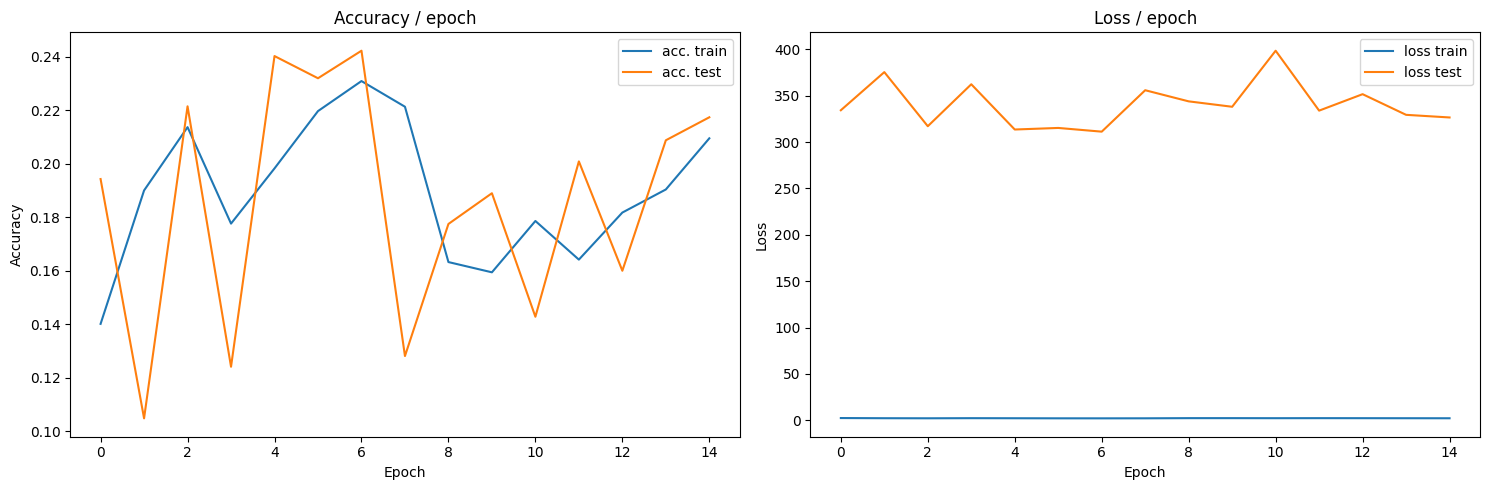

In [37]:
plt.figure(figsize=(15, 5))
# plt.clf()
plt.subplot(1, 2, 1)
plt.plot(np.array(stats_pretrained[0]), label="acc. train")
plt.plot(np.array(stats_pretrained[1]), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(stats_pretrained[2]), label="loss train")
plt.plot(np.array(stats_pretrained[3]), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("stats_vit_pretrained.pdf", dpi=100, bbox_inches="tight")

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.